In [ ]:
import numpy as np

# ----------------------------------------------------------
# Squared Exponential (RBF) Kernel and Derivatives
# ----------------------------------------------------------
def k(x, y, ell=0.2):
    r2 = np.sum((x - y)**2)
    return np.exp(-r2 / (2 * ell**2))

def grad_k_y(x, y, ell=0.2):
    """ Gradient wrt y of k(x, y). """
    return -(y - x) / (ell**2) * k(x, y, ell)

def hess_k_y(x, y, ell=0.2):
    """ Hessian wrt y of k(x, y). """
    diff = (y - x).reshape(-1, 1)
    r = k(x, y, ell)
    d = diff.shape[0]
    term1 = (diff @ diff.T) / (ell**4)
    term2 = np.eye(d) / (ell**2)
    return (term1 - term2) * r

# ----------------------------------------------------------
# Setup: far point x, cluster a,b,c
# ----------------------------------------------------------
x = np.array([2.0, 2.0])        # far away point
a = np.array([0.0, 0.0])
b = np.array([0.1, 0.05])
c = np.array([0.05, 0.15])

points = np.vstack([a, b, c])   # cluster
N = len(points)

# ----------------------------------------------------------
# Kernel matrix K for (a,b,c)
# ----------------------------------------------------------
K = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        K[i, j] = k(points[i], points[j])

print("\nKernel Matrix K:")
print(K)
print("Condition number of K:", np.linalg.cond(K))

# ----------------------------------------------------------
# 1) ALGEBRAIC DIFFERENCING
# ----------------------------------------------------------
# Differences:
# row1 = b - a
# row2 = c - a
v1 = b - a
v2 = c - a

# Construct P_algebraic for 3 points:
P_alg = np.array([
    [-1/np.linalg.norm(v1), +1/np.linalg.norm(v1), 0.0],
    [-1/np.linalg.norm(v2), 0.0, +1/np.linalg.norm(v2)]
])

print("\nAlgebraic P:")
print(P_alg)

# Build preconditioned matrices
K_right_alg = K @ P_alg.T
K_sym_alg   = P_alg @ K @ P_alg.T

print("\nRight-preconditioned (alg): K * P^T")
print(K_right_alg)
print("Condition number (right alg):", np.linalg.cond(K_right_alg))

print("\nSymmetrically preconditioned (alg): P * K * P^T")
print(K_sym_alg)
print("Cond number (sym alg):", np.linalg.cond(K_sym_alg))

# ----------------------------------------------------------
# 2) ANALYTICAL DIFFERENCING
# ----------------------------------------------------------
# Compute analytic gradient + Hessian at cluster center m
m = (a + b + c) / 3

g = grad_k_y(x, m)
H = hess_k_y(x, m)

# Find "principal" analytic directions from Hessian eigenvectors
vals, vecs = np.linalg.eigh(H)
u1 = vecs[:, np.argmax(np.abs(vals))]
u2 = vecs[:, np.argsort(np.abs(vals))[-2]]  # second strongest

# Project cluster points onto these analytic directions
proj = [(p, np.dot((p-m), u1), np.dot((p-m), u2)) for p in [a,b,c]]

# pick the point most aligned with u1 and u2 respectively
p_u1 = max(proj, key=lambda x: abs(x[1]))[0]
p_u2 = max(proj, key=lambda x: abs(x[2]))[0]

# Analytical differences approximate ∂_{u1} k and ∂_{u2} k
# Use finite differences between m and p_u1, m and p_u2
eps1 = np.linalg.norm(p_u1 - m)
eps2 = np.linalg.norm(p_u2 - m)

# Identify index of point nearest p_u1, p_u2
idx1 = np.argmin([np.linalg.norm(p - p_u1) for p in points])
idx2 = np.argmin([np.linalg.norm(p - p_u2) for p in points])
idm  = np.argmin([np.linalg.norm(p - m) for p in points])

# Analytical P:
P_an = np.zeros((2,3))
# row1: along u1 ~ difference between m and p_u1
P_an[0, idm]  = -1/eps1
P_an[0, idx1] = +1/eps1
# row2: along u2 ~ difference between m and p_u2
P_an[1, idm]  = -1/eps2
P_an[1, idx2] = +1/eps2

print("\nAnalytical P:")
print(P_an)

# Preconditioned matrices
K_right_an = K @ P_an.T
K_sym_an   = P_an @ K @ P_an.T

print("\nRight-preconditioned (analytical): K * P^T")
print(K_right_an)
print("Cond number (right analytical):", np.linalg.cond(K_right_an))

print("\nSymmetrically preconditioned (analytical): P * K * P^T")
print(K_sym_an)
print("Cond number (sym analytical):", np.linalg.cond(K_sym_an))

# ----------------------------------------------------------
# Diagnostics
# ----------------------------------------------------------
print("\nEigenvalues of Hessian H at m:", vals)
print("Principal analytic directions u1, u2:\n", u1, "\n", u2)



Kernel Matrix K:
[[1.         0.85534533 0.73161563]
 [0.85534533 1.         0.85534533]
 [0.73161563 0.85534533 1.        ]]
Condition number of K: 25.763564280930964

Algebraic P:
[[-8.94427191  8.94427191  0.        ]
 [-6.32455532  0.          6.32455532]]

Right-preconditioned (alg): K * P^T
[[-1.29383073e+00 -1.69741180e+00]
 [ 1.29383073e+00  5.49256079e-16]
 [ 1.10667207e+00  1.69741180e+00]]
Condition number (right alg): 2.9741359244288716

Symmetrically preconditioned (alg): P * K * P^T
[[23.14474763 15.1821127 ]
 [15.1821127  21.47074968]]
Cond number (sym alg): 5.281589073888965

Analytical P:
[[ 12. -12.   0.]
 [  0. -12.  12.]]

Right-preconditioned (analytical): K * P^T
[[ 1.73585607 -1.48475638]
 [-1.73585607 -1.73585607]
 [-1.48475638  1.73585607]]
Cond number (right analytical): 1.3051176391601413

Symmetrically preconditioned (analytical): P * K * P^T
[[41.66054574  3.0131963 ]
 [ 3.0131963  41.66054574]]
Cond number (sym analytical): 1.1559328827507362

Eigenvalues

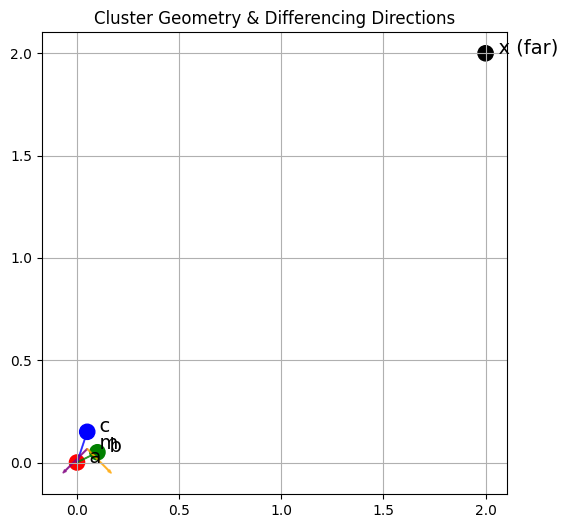

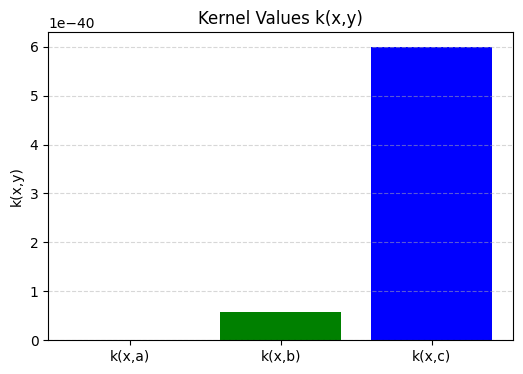

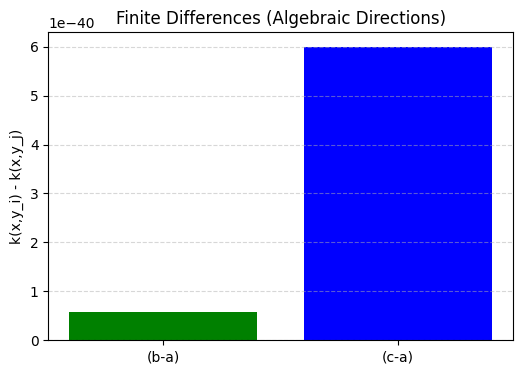

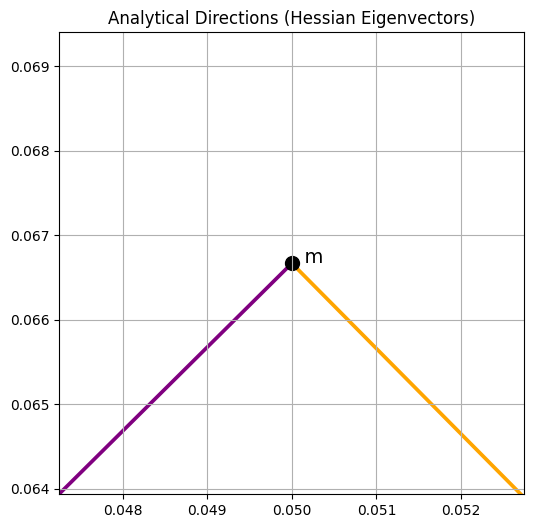

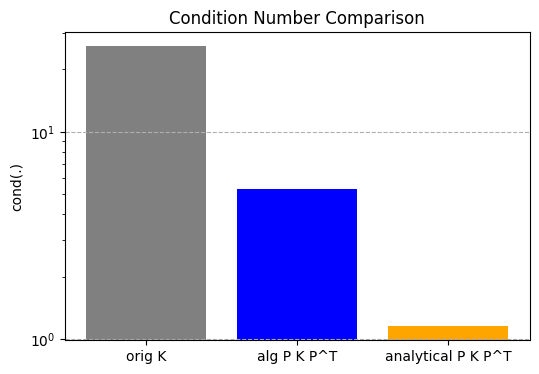

In [ ]:
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Plot 1: Geometry of points and differencing directions
# ----------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter([a[0], b[0], c[0], x[0]], [a[1], b[1], c[1], x[1]],
            color=['red','green','blue','black'], s=120)

plt.text(a[0], a[1], "  a", fontsize=14)
plt.text(b[0], b[1], "  b", fontsize=14)
plt.text(c[0], c[1], "  c", fontsize=14)
plt.text(x[0], x[1], "  x (far)", fontsize=14)

# Algebraic directions (a->b and a->c)
plt.arrow(a[0], a[1], v1[0], v1[1],
          width=0.003, color='green', alpha=0.7, label="alg v1")
plt.arrow(a[0], a[1], v2[0], v2[1],
          width=0.003, color='blue', alpha=0.7, label="alg v2")

# Analytical directions (from m)
m = (a + b + c)/3
scale = 0.15
plt.arrow(m[0], m[1], scale*u1[0], scale*u1[1],
          color='purple', width=0.004, alpha=0.7)
plt.arrow(m[0], m[1], scale*u2[0], scale*u2[1],
          color='orange', width=0.004, alpha=0.7)

plt.text(m[0], m[1], "  m", fontsize=14)

plt.title("Cluster Geometry & Differencing Directions")
plt.grid(True)
plt.axis('equal')
plt.show()


# ----------------------------------------------------------
# Plot 2: Kernel values k(x, y_i)
# ----------------------------------------------------------
k_vals = [k(x, p) for p in [a, b, c]]

plt.figure(figsize=(6,4))
plt.bar(["k(x,a)", "k(x,b)", "k(x,c)"], k_vals, color=["red","green","blue"])
plt.title("Kernel Values k(x,y)")
plt.ylabel("k(x,y)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


# ----------------------------------------------------------
# Plot 3: Kernel differences → directional derivative approx
# ----------------------------------------------------------
diff_alg_1 = k(x,b) - k(x,a)
diff_alg_2 = k(x,c) - k(x,a)

plt.figure(figsize=(6,4))
plt.bar(["(b-a)", "(c-a)"], [diff_alg_1, diff_alg_2],
        color=["green","blue"])
plt.title("Finite Differences (Algebraic Directions)")
plt.ylabel("k(x,y_i) - k(x,y_j)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


# ----------------------------------------------------------
# Plot 4: Hessian eigenvectors (analytical directions)
# ----------------------------------------------------------
plt.figure(figsize=(6,6))
plt.quiver(
    [m[0], m[0]], [m[1], m[1]],
    [u1[0], u2[0]], [u1[1], u2[1]],
    angles='xy', scale_units='xy', scale=1,
    color=['purple','orange'], width=0.008
)
plt.scatter(m[0], m[1], s=100, color='black')
plt.text(m[0], m[1], "  m", fontsize=14)
plt.title("Analytical Directions (Hessian Eigenvectors)")
plt.grid(True)
plt.axis('equal')
plt.show()


# ----------------------------------------------------------
# Plot 5: Condition number comparison
# ----------------------------------------------------------
conds = [
    np.linalg.cond(K),
    np.linalg.cond(K_sym_alg),
    np.linalg.cond(K_sym_an)
]

plt.figure(figsize=(6,4))
plt.bar(["orig K", "alg P K P^T", "analytical P K P^T"], conds,
        color=["gray","blue","orange"])
plt.title("Condition Number Comparison")
plt.ylabel("cond(.)")
plt.yscale('log')
plt.grid(True, axis='y', linestyle='--')
plt.show()


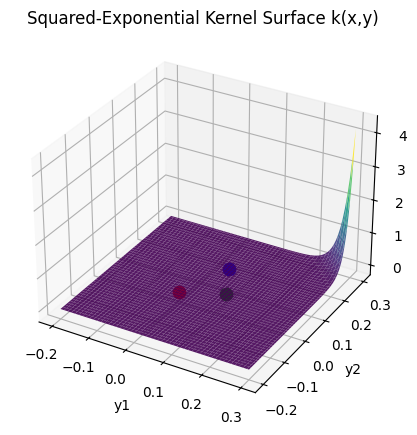

In [ ]:
# ----------------------------------------------------------
# Plot A: SE kernel surface around the cluster
# ----------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D

# Grid for visualization
grid_x = np.linspace(-0.2, 0.3, 100)
grid_y = np.linspace(-0.2, 0.3, 100)
Xg, Yg = np.meshgrid(grid_x, grid_y)

Z = np.zeros_like(Xg)
for i in range(100):
    for j in range(100):
        p = np.array([Xg[i,j], Yg[i,j]])
        Z[i,j] = k(x, p)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Xg, Yg, Z, cmap="viridis", alpha=0.9)

# plot cluster points
ax.scatter(a[0], a[1], k(x,a), color='red', s=80)
ax.scatter(b[0], b[1], k(x,b), color='green', s=80)
ax.scatter(c[0], c[1], k(x,c), color='blue', s=80)
ax.set_title("Squared-Exponential Kernel Surface k(x,y)")
ax.set_xlabel("y1"); ax.set_ylabel("y2")
plt.show()


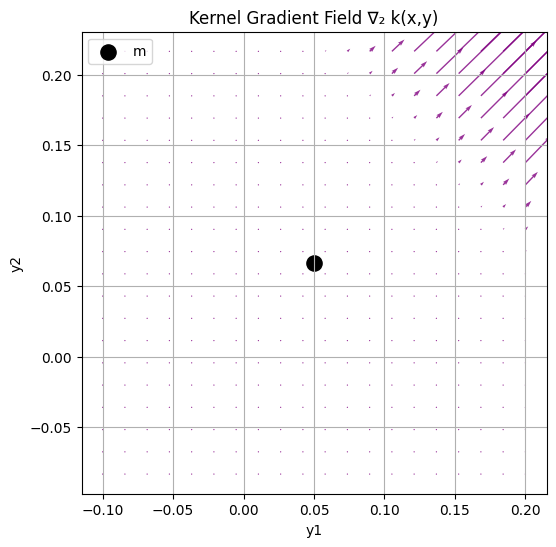

In [ ]:
# ----------------------------------------------------------
# Plot B: Kernel gradient field around cluster center m
# ----------------------------------------------------------
grid_x = np.linspace(m[0]-0.15, m[0]+0.15, 20)
grid_y = np.linspace(m[1]-0.15, m[1]+0.15, 20)
Xg, Yg = np.meshgrid(grid_x, grid_y)

U = np.zeros_like(Xg)
V = np.zeros_like(Yg)

for i in range(20):
    for j in range(20):
        y = np.array([Xg[i,j], Yg[i,j]])
        g = grad_k_y(x, y)
        U[i,j], V[i,j] = g

plt.figure(figsize=(6,6))
plt.quiver(Xg, Yg, U, V, color='purple', alpha=0.8)
plt.scatter(m[0], m[1], color='black', s=120, label='m')

plt.title("Kernel Gradient Field ∇₂ k(x,y)")
plt.xlabel("y1"); plt.ylabel("y2")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


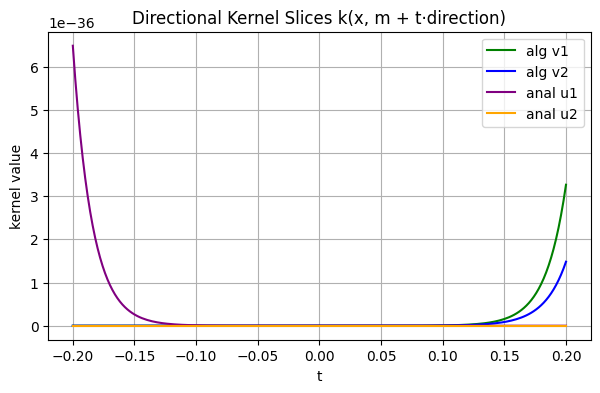

In [ ]:
# ----------------------------------------------------------
# Plot C: Directional derivative curves
# ----------------------------------------------------------

def directional_curve(dir_vec, label, color):
    ts = np.linspace(-0.2, 0.2, 200)
    vals = []
    for t in ts:
        y = m + t * dir_vec
        vals.append(k(x,y))
    plt.plot(ts, vals, label=label, color=color)

plt.figure(figsize=(7,4))
directional_curve(v1/np.linalg.norm(v1), "alg v1", "green")
directional_curve(v2/np.linalg.norm(v2), "alg v2", "blue")
directional_curve(u1, "anal u1", "purple")
directional_curve(u2, "anal u2", "orange")

plt.title("Directional Kernel Slices k(x, m + t·direction)")
plt.xlabel("t"); plt.ylabel("kernel value")
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipython-input-1003583579.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(["a","b","c"], diff_alg, 's-', label="alg differenced", linestyle='--')


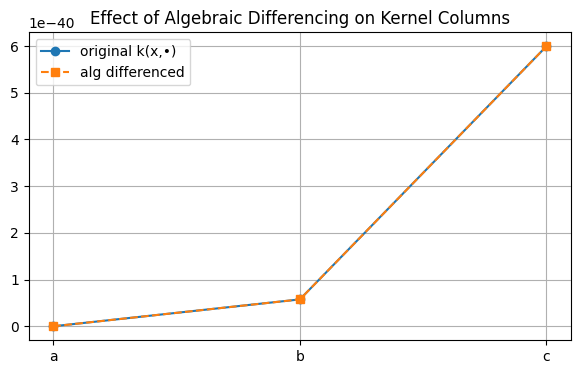

In [ ]:
# ----------------------------------------------------------
# Plot D: Basis functions (original vs differenced)
# ----------------------------------------------------------

plt.figure(figsize=(7,4))

orig = [k(x,a), k(x,b), k(x,c)]
diff_alg = [0, k(x,b)-k(x,a), k(x,c)-k(x,a)]

plt.plot(["a","b","c"], orig, 'o-', label="original k(x,•)")
plt.plot(["a","b","c"], diff_alg, 's-', label="alg differenced", linestyle='--')

plt.title("Effect of Algebraic Differencing on Kernel Columns")
plt.grid(True)
plt.legend()
plt.show()


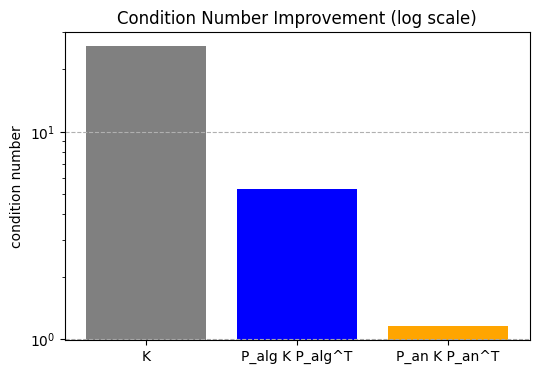

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(
    ["K", "P_alg K P_alg^T", "P_an K P_an^T"],
    [np.linalg.cond(K), np.linalg.cond(K_sym_alg), np.linalg.cond(K_sym_an)],
    color=["gray","blue","orange"]
)
plt.yscale('log')
plt.ylabel("condition number")
plt.title("Condition Number Improvement (log scale)")
plt.grid(True, axis='y', linestyle='--')
plt.show()


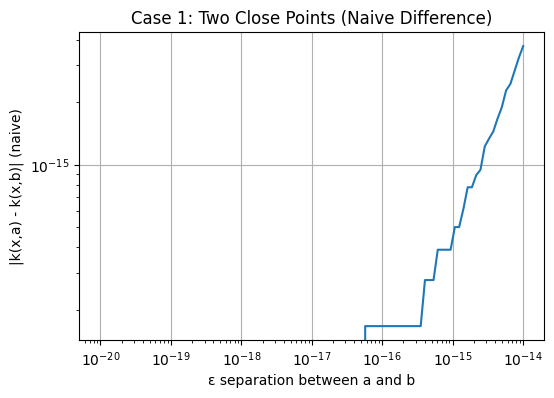

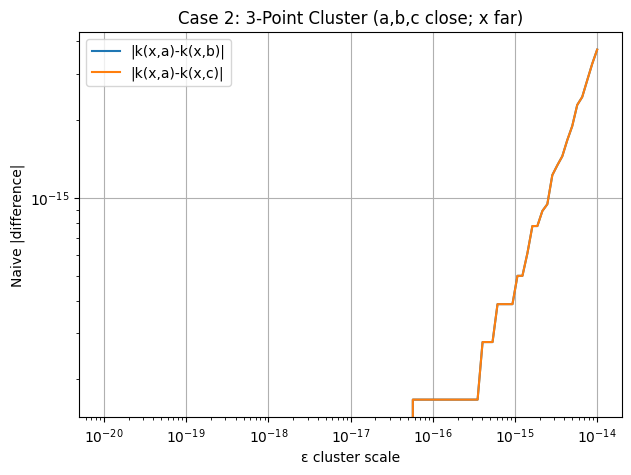

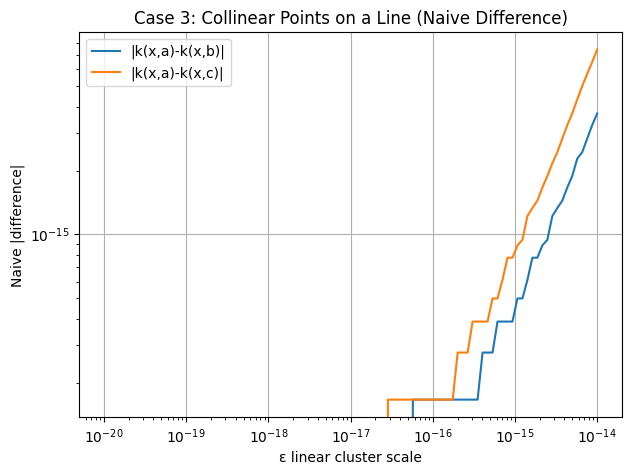

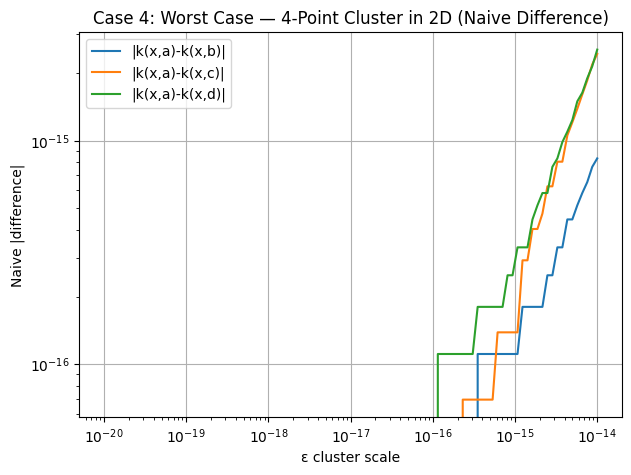

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# Gaussian RBF kernel (naive)
# ==========================================
def k(x, y):
    return np.exp(-0.5 * np.linalg.norm(x - y)**2)

# ==============================================================
# Helper to compute naive kernel differences against far point x
# ==============================================================

def naive_diff(far_x, points):
    """
    far_x = far point (vector)
    points = list of points [p1, p2, ...] that are 'close' to each other
    Returns array of pairwise naive kernel differences:
       k(far_x, p_i) - k(far_x, p_1)
    where p_1 is reference.
    """
    ref = points[0]
    diffs = []
    for p in points:
        diffs.append(k(far_x, ref) - k(far_x, p))
    return np.array(diffs)


# ==============================================================
# CASE 1: Two close points a, b and far point x
# ==============================================================

eps_vals = np.logspace(-14, -20, 100)

diffs_case1 = []
for eps in eps_vals:
    a = np.array([0.0, 0.0])
    b = np.array([eps, 0.0])
    x_far = np.array([1.0, 1.0])
    diffs_case1.append(k(x_far, a) - k(x_far, b))

diffs_case1 = np.array(diffs_case1)

plt.figure(figsize=(6,4))
plt.loglog(eps_vals, np.abs(diffs_case1))
plt.xlabel("ε separation between a and b")
plt.ylabel("|k(x,a) - k(x,b)| (naive)")
plt.title("Case 1: Two Close Points (Naive Difference)")
plt.grid(True)
plt.show()


# ==============================================================
# CASE 2: Cluster a,b,c near each other, x far
# ==============================================================

diffs_case2 = []

for eps in eps_vals:
    a = np.array([0.0,   0.0])
    b = np.array([eps,   0.0])
    c = np.array([0.0, eps])
    x_far = np.array([1.0, 1.0])

    points = [a, b, c]
    diffs = naive_diff(x_far, points)
    diffs_case2.append(diffs)

diffs_case2 = np.array(diffs_case2)

plt.figure(figsize=(7,5))
plt.loglog(eps_vals, np.abs(diffs_case2[:,1]), label="|k(x,a)-k(x,b)|")
plt.loglog(eps_vals, np.abs(diffs_case2[:,2]), label="|k(x,a)-k(x,c)|")
plt.xlabel("ε cluster scale")
plt.ylabel("Naive |difference|")
plt.title("Case 2: 3-Point Cluster (a,b,c close; x far)")
plt.legend()
plt.grid(True)
plt.show()


# ==============================================================
# CASE 3: Linearly dependent (points on a straight line)
# ==============================================================

diffs_case3 = []
for eps in eps_vals:
    a = np.array([0.0, 0.0])
    b = np.array([eps, 0.0])
    c = np.array([2*eps, 0.0])   # still collinear
    x_far = np.array([1.0, -1.0])

    diffs_case3.append(naive_diff(x_far, [a, b, c]))

diffs_case3 = np.array(diffs_case3)

plt.figure(figsize=(7,5))
plt.loglog(eps_vals, np.abs(diffs_case3[:,1]), label="|k(x,a)-k(x,b)|")
plt.loglog(eps_vals, np.abs(diffs_case3[:,2]), label="|k(x,a)-k(x,c)|")
plt.xlabel("ε linear cluster scale")
plt.ylabel("Naive |difference|")
plt.title("Case 3: Collinear Points on a Line (Naive Difference)")
plt.legend()
plt.grid(True)
plt.show()


# ==============================================================
# CASE 4: Worst case — 4 vectors in 2D all clustered and all interacting
# ==============================================================

diffs_case4 = []
for eps in eps_vals:
    # tightly clustered 2D shape collapsing to a point
    a = np.array([0.0,    0.0])
    b = np.array([ eps,    eps])    # NE
    c = np.array([-eps,    eps])    # NW
    d = np.array([ eps,   -eps])    # SE

    x_far = np.array([2.0, -1.0])   # fixed far point

    points = [a, b, c, d]
    diffs_case4.append(naive_diff(x_far, points))

diffs_case4 = np.array(diffs_case4)

plt.figure(figsize=(7,5))
plt.loglog(eps_vals, np.abs(diffs_case4[:,1]), label="|k(x,a)-k(x,b)|")
plt.loglog(eps_vals, np.abs(diffs_case4[:,2]), label="|k(x,a)-k(x,c)|")
plt.loglog(eps_vals, np.abs(diffs_case4[:,3]), label="|k(x,a)-k(x,d)|")
plt.xlabel("ε cluster scale")
plt.ylabel("Naive |difference|")
plt.title("Case 4: Worst Case — 4-Point Cluster in 2D (Naive Difference)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ---------------------------
# # Utility: squared-exponential kernel (for reference)
# # ---------------------------
# def k(x, y):
#     return np.exp(-0.5 * np.linalg.norm(x - y)**2)

# # ---------------------------
# # Stable difference using your exact expansion style
# # Computes: k(x, j) - k(x, k)
# # where i (in earlier notes) corresponds to evaluation point xi,
# # and j/k correspond to the two nearby points.
# # Use variable names matching your snippet:
# #   xi = evaluation point (far)
# #   xj, xk = two nearby points
# # stable = exp(-rho_ik^2/2) * expm1( (rho_ik^2 - rho_ij^2)/2 )
# # but implemented via the dot-product identity:
# #   diff_sq = dot(rjk, 2*rij + rjk)
# # ---------------------------
# def stable_diff_using_dot_identity(xi, xj, xk):
#     # vectors as in your snippet
#     rik = xi - xk   # xi - xk
#     rij = xi - xj   # xi - xj
#     rjk = xj - xk   # xj - xk

#     rho_ik2 = np.dot(rik, rik)
#     # identity: rho_ik2 - rho_ij2 = dot(rjk, 2*rij + rjk)
#     diff_sq = np.dot(rjk, 2 * rij + rjk)

#     return np.exp(-rho_ik2 / 2.0) * np.expm1(diff_sq / 2.0)


# # ---------------------------
# # Experiment parameters
# # ---------------------------
# epsilons = np.logspace(-14, -20, 300)
# xi = np.array([1.0, 0.0])   # fixed far evaluation point used in Case 0 demonstration

# # ---------------------------
# # Quick sanity demo (single j->k approach: reproduce your original snippet)
# # ---------------------------
# xj = np.array([0.0, 0.0])
# diff_naive_demo = []
# diff_stable_demo = []
# for eps in epsilons:
#     xk = np.array([eps, 0.0])
#     rho_ij = np.linalg.norm(xi - xj)
#     rho_ik = np.linalg.norm(xi - xk)

#     naive = np.exp(-rho_ij**2/2.0) - np.exp(-rho_ik**2/2.0)
#     diff_naive_demo.append(naive)

#     stable = stable_diff_using_dot_identity(xi, xj, xk)
#     diff_stable_demo.append(stable)

# diff_naive_demo = np.array(diff_naive_demo)
# diff_stable_demo = np.array(diff_stable_demo)

# plt.figure(figsize=(6,4))
# plt.plot(epsilons, diff_naive_demo, label="Naive", linewidth=1)
# plt.plot(epsilons, diff_stable_demo, label="Stable (dot-identity + expm1)", linestyle='--', linewidth=1)
# plt.xscale('log')
# plt.xlabel("ε (distance j→k)")
# plt.ylabel("k(x,j) - k(x,k)")
# plt.title("Demo: Naive vs Stable (single j,k)")
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(6,4))
# plt.loglog(epsilons, np.abs(diff_naive_demo)+1e-320, label="|Naive|")   # tiny shift to avoid zeros on plot
# plt.loglog(epsilons, np.abs(diff_stable_demo)+1e-320, label="|Stable|", linestyle='--')
# plt.xlabel("ε (distance j→k)")
# plt.ylabel("|difference| (log-log)")
# plt.title("Magnitude comparison")
# plt.legend()
# plt.grid(False)
# plt.show()

# print("Example stable outputs (last 8):")
# for val in diff_stable_demo[-8:]:
#     print(f"{val:.3e}")


# # ---------------------------
# # CASE 1: two close points a,b and far x
# # ---------------------------
# xi_case1 = np.array([1.0, 1.0])  # far evaluation point
# diffs_case1_stable = []
# diffs_case1_naive  = []

# for eps in epsilons:
#     a = np.array([0.0, 0.0])
#     b = np.array([eps, 0.0])

#     naive = np.exp(-np.linalg.norm(xi_case1 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case1 - b)**2/2.0)
#     stable = stable_diff_using_dot_identity(xi_case1, a, b)

#     diffs_case1_naive.append(naive)
#     diffs_case1_stable.append(stable)

# diffs_case1_naive = np.array(diffs_case1_naive)
# diffs_case1_stable = np.array(diffs_case1_stable)

# plt.figure(figsize=(6,4))
# plt.loglog(epsilons, np.abs(diffs_case1_naive)+1e-320, label="|Naive|")
# plt.loglog(epsilons, np.abs(diffs_case1_stable)+1e-320, label="|Stable|", linestyle='--')
# plt.xlabel("ε")
# plt.ylabel("|k(x,a)-k(x,b)|")
# plt.title("Case 1: Two close points (naive vs stable)")
# plt.legend()
# plt.grid(True)
# plt.show()


# # ---------------------------
# # CASE 2: cluster of points a,b,c near each other and x far
# # ---------------------------
# xi_case2 = np.array([1.0, 1.0])
# diffs_case2_naive = []
# diffs_case2_stable = []

# for eps in epsilons:
#     a = np.array([0.0, 0.0])
#     b = np.array([eps, 0.0])
#     c = np.array([0.0, eps])

#     # differences relative to a
#     naive_ab = np.exp(-np.linalg.norm(xi_case2 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case2 - b)**2/2.0)
#     naive_ac = np.exp(-np.linalg.norm(xi_case2 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case2 - c)**2/2.0)

#     stable_ab = stable_diff_using_dot_identity(xi_case2, a, b)
#     stable_ac = stable_diff_using_dot_identity(xi_case2, a, c)

#     diffs_case2_naive.append([naive_ab, naive_ac])
#     diffs_case2_stable.append([stable_ab, stable_ac])

# diffs_case2_naive = np.array(diffs_case2_naive)
# diffs_case2_stable = np.array(diffs_case2_stable)

# plt.figure(figsize=(7,5))
# plt.loglog(epsilons, np.abs(diffs_case2_naive[:,0])+1e-320, label="|Naive a-b|")
# plt.loglog(epsilons, np.abs(diffs_case2_stable[:,0])+1e-320, label="|Stable a-b|", linestyle='--')
# plt.loglog(epsilons, np.abs(diffs_case2_naive[:,1])+1e-320, label="|Naive a-c|", alpha=0.6)
# plt.loglog(epsilons, np.abs(diffs_case2_stable[:,1])+1e-320, label="|Stable a-c|", linestyle='--', alpha=0.6)
# plt.xlabel("ε")
# plt.ylabel("|difference|")
# plt.title("Case 2: 3-point cluster (naive vs stable)")
# plt.legend()
# plt.grid(True)
# plt.show()


# # ---------------------------
# # CASE 3: collinear / linearly dependent points
# # ---------------------------
# xi_case3 = np.array([1.0, -1.0])
# diffs_case3_naive = []
# diffs_case3_stable = []

# for eps in epsilons:
#     a = np.array([0.0, 0.0])
#     b = np.array([eps, 0.0])
#     c = np.array([2*eps, 0.0])

#     naive_ab = np.exp(-np.linalg.norm(xi_case3 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case3 - b)**2/2.0)
#     naive_ac = np.exp(-np.linalg.norm(xi_case3 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case3 - c)**2/2.0)

#     stable_ab = stable_diff_using_dot_identity(xi_case3, a, b)
#     stable_ac = stable_diff_using_dot_identity(xi_case3, a, c)

#     diffs_case3_naive.append([naive_ab, naive_ac])
#     diffs_case3_stable.append([stable_ab, stable_ac])

# diffs_case3_naive = np.array(diffs_case3_naive)
# diffs_case3_stable = np.array(diffs_case3_stable)

# plt.figure(figsize=(7,5))
# plt.loglog(epsilons, np.abs(diffs_case3_naive[:,0])+1e-320, label="|Naive a-b|")
# plt.loglog(epsilons, np.abs(diffs_case3_stable[:,0])+1e-320, label="|Stable a-b|", linestyle='--')
# plt.loglog(epsilons, np.abs(diffs_case3_naive[:,1])+1e-320, label="|Naive a-c|", alpha=0.6)
# plt.loglog(epsilons, np.abs(diffs_case3_stable[:,1])+1e-320, label="|Stable a-c|", linestyle='--', alpha=0.6)
# plt.xlabel("ε")
# plt.ylabel("|difference|")
# plt.title("Case 3: Collinear cluster (naive vs stable)")
# plt.legend()
# plt.grid(True)
# plt.show()


# # ---------------------------
# # CASE 4: 4-point 2D cluster
# # ---------------------------
# xi_case4 = np.array([2.0, -1.0])
# diffs_case4_naive = []
# diffs_case4_stable = []

# for eps in epsilons:
#     a = np.array([0.0, 0.0])
#     b = np.array([ eps, eps])
#     c = np.array([-eps, eps])
#     d = np.array([ eps, -eps])

#     naive_ab = np.exp(-np.linalg.norm(xi_case4 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case4 - b)**2/2.0)
#     naive_ac = np.exp(-np.linalg.norm(xi_case4 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case4 - c)**2/2.0)
#     naive_ad = np.exp(-np.linalg.norm(xi_case4 - a)**2/2.0) - np.exp(-np.linalg.norm(xi_case4 - d)**2/2.0)

#     stable_ab = stable_diff_using_dot_identity(xi_case4, a, b)
#     stable_ac = stable_diff_using_dot_identity(xi_case4, a, c)
#     stable_ad = stable_diff_using_dot_identity(xi_case4, a, d)

#     diffs_case4_naive.append([naive_ab, naive_ac, naive_ad])
#     diffs_case4_stable.append([stable_ab, stable_ac, stable_ad])

# diffs_case4_naive = np.array(diffs_case4_naive)
# diffs_case4_stable = np.array(diffs_case4_stable)

# plt.figure(figsize=(8,5))
# plt.loglog(epsilons, np.abs(diffs_case4_naive[:,0])+1e-320, label="|Naive a-b|")
# plt.loglog(epsilons, np.abs(diffs_case4_stable[:,0])+1e-320, label="|Stable a-b|", linestyle='--')
# plt.loglog(epsilons, np.abs(diffs_case4_naive[:,1])+1e-320, label="|Naive a-c|", alpha=0.6)
# plt.loglog(epsilons, np.abs(diffs_case4_stable[:,1])+1e-320, label="|Stable a-c|", linestyle='--', alpha=0.6)
# plt.loglog(epsilons, np.abs(diffs_case4_naive[:,2])+1e-320, label="|Naive a-d|", alpha=0.4)
# plt.loglog(epsilons, np.abs(diffs_case4_stable[:,2])+1e-320, label="|Stable a-d|", linestyle='--', alpha=0.4)
# plt.xlabel("ε")
# plt.ylabel("|difference|")
# plt.title("Case 4: 4-point 2D cluster (naive vs stable)")
# plt.legend()
# plt.grid(True)
# plt.show()

# print("Done. All cases computed using the dot-identity form + expm1 (exactly as in your snippet).")


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ==========================================
# # Gaussian RBF kernel (naive)
# # ==========================================
# def k(x, y):
#     return np.exp(-0.5 * np.linalg.norm(x - y)**2)

# # ==========================================
# # Stable kernel difference
# # k(xi,xk) - k(xi,xj)
# # ==========================================
# def stable_diff(xi, xk, xj):
#     rho_ik = np.linalg.norm(xi - xk)
#     rho_ij = np.linalg.norm(xi - xj)

#     return np.exp(-rho_ik**2/2) * np.expm1((rho_ik**2 - rho_ij**2)/2)

# # ==========================================
# # Helper for naive cluster differences
# # ==========================================
# def naive_diff(far_x, points):
#     ref = points[0]
#     diffs = []
#     for p in points:
#         diffs.append(k(far_x, ref) - k(far_x, p))
#     return np.array(diffs)

# # ==========================================
# # Helper for stable cluster differences
# # ==========================================
# def stable_cluster_diff(far_x, points):
#     ref = points[0]
#     diffs = []
#     for p in points:
#         rho_ik = np.linalg.norm(far_x - p)
#         rho_ij = np.linalg.norm(far_x - ref)
#         diffs.append(np.exp(-rho_ik**2/2) * np.expm1((rho_ik**2 - rho_ij**2)/2))
#     return np.array(diffs)



# # ==============================================================
# # CASE 1: Two close points a, b and far point x
# # ==============================================================
# eps_vals = np.logspace(-14, -20, 100)

# naive_case1 = []
# stable_case1 = []

# for eps in eps_vals:
#     a = np.array([0.0, 0.0])
#     b = np.array([eps, 0.0])
#     x_far = np.array([1.0, 1.0])

#     # naive
#     naive_case1.append(k(x_far, a) - k(x_far, b))

#     # stable
#     stable_case1.append(stable_diff(x_far, b, a))

# naive_case1 = np.array(naive_case1)
# stable_case1 = np.array(stable_case1)

# plt.figure(figsize=(6,4))
# plt.loglog(eps_vals, np.abs(naive_case1), label="Naive")
# plt.loglog(eps_vals, np.abs(stable_case1), label="Stable")
# plt.xlabel("ε separation")
# plt.ylabel("|difference|")
# plt.title("Case 1: Two Close Points — Naive vs Stable")
# plt.legend()
# plt.grid(True)
# plt.show()



# # ==============================================================
# # CASE 2: a,b,c cluster near each other, x far
# # ==============================================================
# naive_case2 = []
# stable_case2 = []

# for eps in eps_vals:
#     a = np.array([0.0, 0.0])
#     b = np.array([eps, 0.0])
#     c = np.array([0.0, eps])
#     x_far = np.array([1.0, 1.0])

#     pts = [a, b, c]

#     naive_case2.append(naive_diff(x_far, pts))
#     stable_case2.append(stable_cluster_diff(x_far, pts))

# naive_case2 = np.array(naive_case2)
# stable_case2 = np.array(stable_case2)

# plt.figure(figsize=(7,5))
# plt.loglog(eps_vals, np.abs(naive_case2[:,1]), '--', label="Naive: a-b")
# plt.loglog(eps_vals, np.abs(naive_case2[:,2]), '--', label="Naive: a-c")

# plt.loglog(eps_vals, np.abs(stable_case2[:,1]), label="Stable: a-b")
# plt.loglog(eps_vals, np.abs(stable_case2[:,2]), label="Stable: a-c")

# plt.xlabel("ε cluster scale")
# plt.ylabel("|difference|")
# plt.title("Case 2: 3-Point Cluster — Naive vs Stable")
# plt.legend()
# plt.grid(True)
# plt.show()



# # ==============================================================
# # CASE 3: Collinear points
# # ==============================================================
# naive_case3 = []
# stable_case3 = []

# for eps in eps_vals:
#     a = np.array([0.0, 0.0])
#     b = np.array([eps, 0.0])
#     c = np.array([2*eps, 0.0])
#     x_far = np.array([1.0, -1.0])

#     pts = [a,b,c]

#     naive_case3.append(naive_diff(x_far, pts))
#     stable_case3.append(stable_cluster_diff(x_far, pts))

# naive_case3 = np.array(naive_case3)
# stable_case3 = np.array(stable_case3)

# plt.figure(figsize=(7,5))
# plt.loglog(eps_vals, np.abs(naive_case3[:,1]), '--', label="Naive: a-b")
# plt.loglog(eps_vals, np.abs(naive_case3[:,2]), '--', label="Naive: a-c")

# plt.loglog(eps_vals, np.abs(stable_case3[:,1]), label="Stable: a-b")
# plt.loglog(eps_vals, np.abs(stable_case3[:,2]), label="Stable: a-c")

# plt.xlabel("ε linear scale")
# plt.ylabel("|difference|")
# plt.title("Case 3: Collinear Cluster — Naive vs Stable")
# plt.legend()
# plt.grid(True)
# plt.show()



# # ==============================================================
# # CASE 4: Worst-case 4-point 2D cluster
# # ==============================================================
# naive_case4 = []
# stable_case4 = []

# for eps in eps_vals:
#     a = np.array([0.0, 0.0])
#     b = np.array([ eps,  eps])
#     c = np.array([-eps,  eps])
#     d = np.array([ eps, -eps])
#     x_far = np.array([2.0, -1.0])

#     pts = [a,b,c,d]

#     naive_case4.append(naive_diff(x_far, pts))
#     stable_case4.append(stable_cluster_diff(x_far, pts))

# naive_case4 = np.array(naive_case4)
# stable_case4 = np.array(stable_case4)

# plt.figure(figsize=(7,5))
# plt.loglog(eps_vals, np.abs(naive_case4[:,1]), '--', label="Naive: a-b")
# plt.loglog(eps_vals, np.abs(naive_case4[:,2]), '--', label="Naive: a-c")
# plt.loglog(eps_vals, np.abs(naive_case4[:,3]), '--', label="Naive: a-d")

# plt.loglog(eps_vals, np.abs(stable_case4[:,1]), label="Stable: a-b")
# plt.loglog(eps_vals, np.abs(stable_case4[:,2]), label="Stable: a-c")
# plt.loglog(eps_vals, np.abs(stable_case4[:,3]), label="Stable: a-d")

# plt.xlabel("ε cluster scale")
# plt.ylabel("|difference|")
# plt.title("Case 4: 4-Point 2D Cluster — Naive vs Stable")
# plt.legend()
# plt.grid(True)
# plt.show()


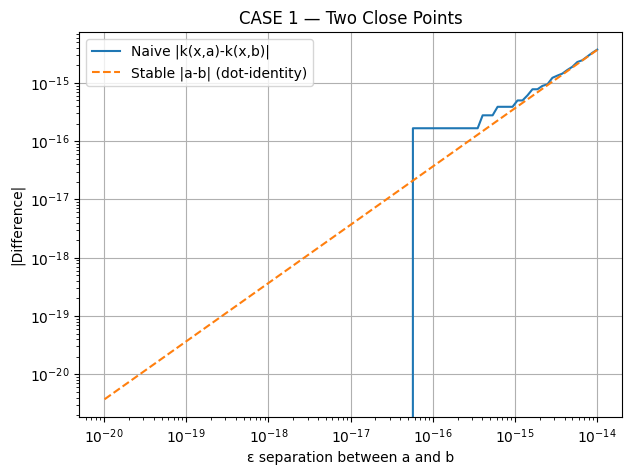

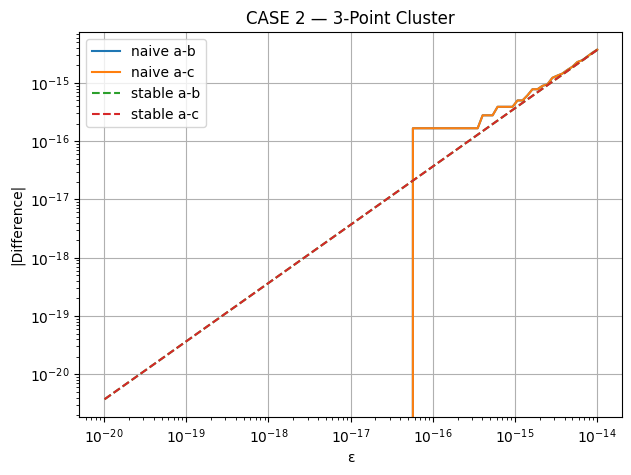

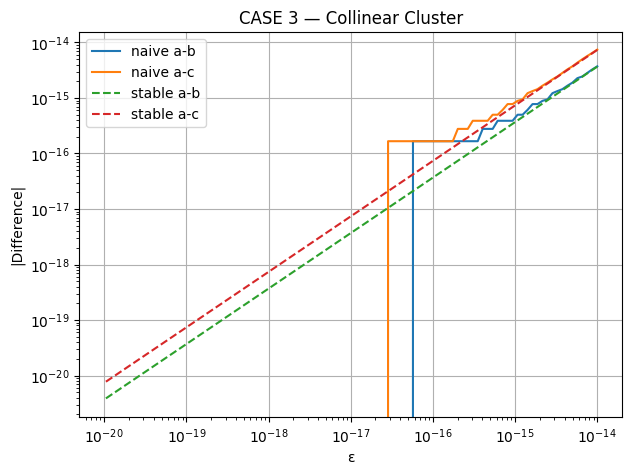

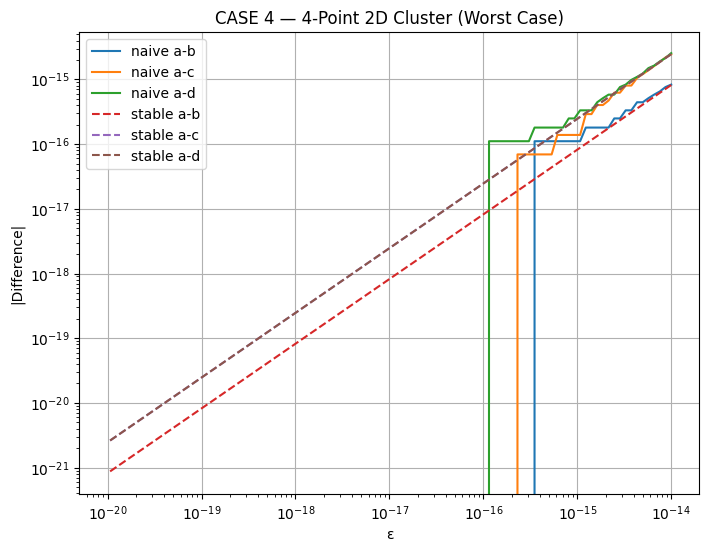

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# Gaussian RBF kernel (naive)
# ==========================================
def k(x, y):
    return np.exp(-0.5 * np.linalg.norm(x - y)**2)


# ==============================================================
# Stable difference using DOT-IDENTITY formula
#
# k(xi,xj) - k(xi,xk)  (with j = ref)
#
# Uses:
#  rik = xi - xk
#  rij = xi - xj
#  rjk = xj - xk
#
#  rho_ik^2 - rho_ij^2 = dot(rjk, 2*rij + rjk)
#
# Stable difference:
#  exp(-rho_ik^2 / 2) * expm1( diff_sq / 2 )
# ==============================================================

def stable_diff_using_dot_identity(xi, xj, xk):
    rik = xi - xk
    rij = xi - xj
    rjk = xj - xk

    rho_ik2 = np.dot(rik, rik)
    diff_sq = np.dot(rjk, 2 * rij + rjk)

    return np.exp(-rho_ik2 / 2.0) * np.expm1(diff_sq / 2.0)


# ==============================================================
# Helpers for cluster differences (naive + stable)
# ==============================================================

def naive_cluster_diff(far_x, points):
    """
    naive: k(far_x, ref) - k(far_x, p)
    ref = points[0]
    """
    ref = points[0]
    return np.array([k(far_x, ref) - k(far_x, p) for p in points])


def stable_cluster_diff(far_x, points):
    """
    stable: stable_diff_using_dot_identity(far_x, ref, p)
    """
    ref = points[0]
    return np.array([stable_diff_using_dot_identity(far_x, ref, p) for p in points])


# ==============================================================
# CASE 1: Two close points
# ==============================================================
eps_vals = np.logspace(-14, -20, 100)
naive_case1 = []
stable_case1 = []

for eps in eps_vals:
    a = np.array([0.0, 0.0])
    b = np.array([eps, 0.0])
    x_far = np.array([1.0, 1.0])

    naive_case1.append(k(x_far, a) - k(x_far, b))
    stable_case1.append(stable_diff_using_dot_identity(x_far, a, b))

naive_case1 = np.array(naive_case1)
stable_case1 = np.array(stable_case1)

plt.figure(figsize=(7,5))
plt.loglog(eps_vals, np.abs(naive_case1), label="Naive |k(x,a)-k(x,b)|")
plt.loglog(eps_vals, np.abs(stable_case1), '--', label="Stable |a-b| (dot-identity)")
plt.xlabel("ε separation between a and b")
plt.ylabel("|Difference|")
plt.title("CASE 1 — Two Close Points")
plt.legend(); plt.grid(True)
plt.show()


# ==============================================================
# CASE 2: Three-point cluster
# ==============================================================
naive_case2 = []
stable_case2 = []

for eps in eps_vals:
    a = np.array([0.0, 0.0])
    b = np.array([eps, 0.0])
    c = np.array([0.0, eps])
    x_far = np.array([1.0, 1.0])

    pts = [a, b, c]
    naive_case2.append(naive_cluster_diff(x_far, pts))
    stable_case2.append(stable_cluster_diff(x_far, pts))

naive_case2 = np.array(naive_case2)
stable_case2 = np.array(stable_case2)

plt.figure(figsize=(7,5))
plt.loglog(eps_vals, np.abs(naive_case2[:,1]), label="naive a-b")
plt.loglog(eps_vals, np.abs(naive_case2[:,2]), label="naive a-c")
plt.loglog(eps_vals, np.abs(stable_case2[:,1]), '--', label="stable a-b")
plt.loglog(eps_vals, np.abs(stable_case2[:,2]), '--', label="stable a-c")
plt.xlabel("ε")
plt.ylabel("|Difference|")
plt.title("CASE 2 — 3-Point Cluster")
plt.legend(); plt.grid(True)
plt.show()


# ==============================================================
# CASE 3: Collinear points (line degeneracy)
# ==============================================================
naive_case3 = []
stable_case3 = []

for eps in eps_vals:
    a = np.array([0.0, 0.0])
    b = np.array([eps, 0.0])
    c = np.array([2*eps, 0.0])
    x_far = np.array([1.0, -1.0])

    pts = [a, b, c]
    naive_case3.append(naive_cluster_diff(x_far, pts))
    stable_case3.append(stable_cluster_diff(x_far, pts))

naive_case3 = np.array(naive_case3)
stable_case3 = np.array(stable_case3)

plt.figure(figsize=(7,5))
plt.loglog(eps_vals, np.abs(naive_case3[:,1]), label="naive a-b")
plt.loglog(eps_vals, np.abs(naive_case3[:,2]), label="naive a-c")
plt.loglog(eps_vals, np.abs(stable_case3[:,1]), '--', label="stable a-b")
plt.loglog(eps_vals, np.abs(stable_case3[:,2]), '--', label="stable a-c")
plt.xlabel("ε")
plt.ylabel("|Difference|")
plt.title("CASE 3 — Collinear Cluster")
plt.legend(); plt.grid(True)
plt.show()


# ==============================================================
# CASE 4: Worst 2D 4-point cluster
# ==============================================================
naive_case4 = []
stable_case4 = []

for eps in eps_vals:
    a = np.array([0.0, 0.0])
    b = np.array([ eps,  eps])
    c = np.array([-eps,  eps])
    d = np.array([ eps, -eps])
    x_far = np.array([2.0, -1.0])

    pts = [a, b, c, d]
    naive_case4.append(naive_cluster_diff(x_far, pts))
    stable_case4.append(stable_cluster_diff(x_far, pts))

naive_case4 = np.array(naive_case4)
stable_case4 = np.array(stable_case4)

plt.figure(figsize=(8,6))
plt.loglog(eps_vals, np.abs(naive_case4[:,1]), label="naive a-b")
plt.loglog(eps_vals, np.abs(naive_case4[:,2]), label="naive a-c")
plt.loglog(eps_vals, np.abs(naive_case4[:,3]), label="naive a-d")
plt.loglog(eps_vals, np.abs(stable_case4[:,1]), '--', label="stable a-b")
plt.loglog(eps_vals, np.abs(stable_case4[:,2]), '--', label="stable a-c")
plt.loglog(eps_vals, np.abs(stable_case4[:,3]), '--', label="stable a-d")
plt.xlabel("ε")
plt.ylabel("|Difference|")
plt.title("CASE 4 — 4-Point 2D Cluster (Worst Case)")
plt.legend(); plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import numpy.linalg as LA

# ==========================================================
# 1. Define the squared exponential kernel
# ==========================================================
def k(x, y, ell=0.1):
    return np.exp(-np.sum((x - y)**2) / (2 * ell**2))

# ==========================================================
# 2. Define three collinear points (cluster)
# ==========================================================
a = np.array([0.00])
b = np.array([0.01])
c = np.array([0.02])

points = [a, b, c]
N = 3

# ==========================================================
# 3. Build the 3x3 kernel matrix K
# ==========================================================
K = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        K[i,j] = k(points[i], points[j])

print("\n================ KERNEL MATRIX K ================")
print(K)
print("cond(K) =", LA.cond(K))
print("eigs(K) =", LA.eigvals(K))

# ==========================================================
# 4. Differencing matrix P for collinear cluster
# ==========================================================
h = 0.01  # spacing
P = np.array([
    [-1/h,  1/h, 0   ],
    [ 0,   -1/h, 1/h ]
])

print("\n================ DIFFERENCING MATRIX P ================")
print(P)

# ==========================================================
# 5. RIGHT PRECONDITIONING: KP^T
# ==========================================================
K_right = K @ P.T

print("\n================ RIGHT PRECONDITIONING K * P^T ================")
print(K_right)
print("cond(KP^T) =", LA.cond(K_right))
print("Rank(KP^T) =", LA.matrix_rank(K_right))

# ==========================================================
# 6. LEFT+RIGHT PRECONDITIONING: P^T K P
# ==========================================================
# K_sym = P.T @ K @ P
K_sym = P @ K @ P.T

print("\n================ SYMMETRIC PRECONDITIONING P^T K P ================")
print(K_sym)
print("cond(P^T K P) =", LA.cond(K_sym))
print("Rank(P^T K P) =", LA.matrix_rank(K_sym))
print("eigs(P^T K P) =", LA.eigvals(K_sym))

# ==========================================================
# 7. Interpret rank deficiency
# ==========================================================
print("\n================ INTERPRETATION ================")
print("Since a,b,c are collinear, P extracts only ONE valid derivative direction.")
print("→ The symmetric matrix P^T K P has rank 1.")
print("→ This is the BEST possible preconditioning for a 1-D cluster.")
print("→ Right-preconditioning loses symmetry; left+right preserves structure.")



================ KERNEL MATRIX K ================
[[1.         0.99501248 0.98019867]
 [0.99501248 1.         0.99501248]
 [0.98019867 0.99501248 1.        ]]
cond(K) = 89705.7077906722
eigs(K) = [2.98016545e+00 1.98013267e-02 3.32215812e-05]

================ DIFFERENCING MATRIX P ================
[[-100.  100.    0.]
 [   0. -100.  100.]]

================ RIGHT PRECONDITIONING K * P^T ================
[[-0.49875208 -1.48138059]
 [ 0.49875208 -0.49875208]
 [ 1.48138059  0.49875208]]
cond(KP^T) = 1.6370514209338183
Rank(KP^T) = 2

================ SYMMETRIC PRECONDITIONING P^T K P ================
[[99.75041615 98.26285079]
 [98.26285079 99.75041615]]
cond(P^T K P) = 133.11231373257831
Rank(P^T K P) = 2
eigs(P^T K P) = [198.01326693   1.48756536]

================ INTERPRETATION ================
Since a,b,c are collinear, P extracts only ONE valid derivative direction.
→ The symmetric matrix P^T K P has rank 1.
→ This is the BEST possible preconditioning for a 1-D cluster.
→ Right-pr

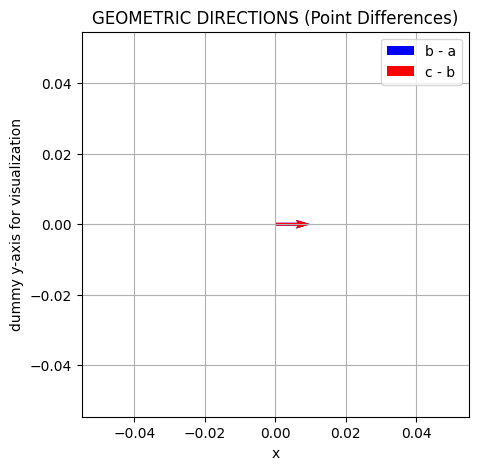

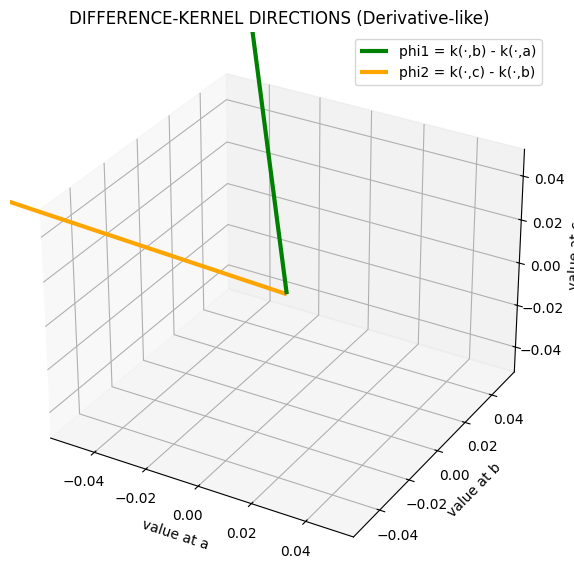


Angle between geometric directions (v1, v2) = 0.0 degrees
Angle between difference-kernel directions = 62.837707379324456 degrees


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1. Squared Exponential kernel
# ==========================================================
def k(x, y, ell=0.1):
    return np.exp(-np.sum((x - y)**2) / (2 * ell**2))

# ==========================================================
# 2. Choose collinear points
# ==========================================================
a = np.array([0.00])
b = np.array([0.01])
c = np.array([0.02])

# Put them into an array for convenience
points = [a, b, c]

# ==========================================================
# 3. Geometric direction vectors
# ==========================================================
v1 = b - a    # geometric direction a→b
v2 = c - b    # geometric direction b→c

# ==========================================================
# 4. Difference-kernel direction vectors
# ==========================================================
kd1 = k(a,a) - k(a,b)   # difference in kernel values at a
kd2 = k(a,b) - k(a,c)

# but easier: consider differences in the kernel columns
K = np.array([
    [ k(a,a), k(a,b), k(a,c) ],
    [ k(b,a), k(b,b), k(b,c) ],
    [ k(c,a), k(c,b), k(c,c) ]
])

# difference kernel columns
phi1 = K[:,1] - K[:,0]   # k(·,b) - k(·,a)
phi2 = K[:,2] - K[:,1]   # k(·,c) - k(·,b)

# Normalize for visualization
phi1_dir = phi1 / np.linalg.norm(phi1)
phi2_dir = phi2 / np.linalg.norm(phi2)

# ==========================================================
# 5. PLOT A: Geometric directions
# ==========================================================
plt.figure(figsize=(5,5))
plt.title("GEOMETRIC DIRECTIONS (Point Differences)")
origin = np.array([[0, 0]])  # plot from origin

plt.quiver(*origin.T, v1, [0], angles='xy', scale_units='xy', scale=1,
           color='blue', label='b - a')

plt.quiver(*origin.T, v2, [0], angles='xy', scale_units='xy', scale=1,
           color='red', label='c - b')

plt.legend()
plt.grid(True)
plt.xlabel("x")
plt.ylabel("dummy y-axis for visualization")
plt.axis('equal')
plt.show()

# ==========================================================
# 6. PLOT B: Difference-kernel directions (3D plot, FIXED)
# ==========================================================
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("DIFFERENCE-KERNEL DIRECTIONS (Derivative-like)")

# origin in 3D (for plotting phi1 and phi2)
ox, oy, oz = 0, 0, 0

# Plot phi1 direction (normalized)
ax.quiver(
    ox, oy, oz,
    phi1_dir[0], phi1_dir[1], phi1_dir[2],
    color='green', linewidth=3,
    label="phi1 = k(·,b) - k(·,a)"
)

# Plot phi2 direction (normalized)
ax.quiver(
    ox, oy, oz,
    phi2_dir[0], phi2_dir[1], phi2_dir[2],
    color='orange', linewidth=3,
    label="phi2 = k(·,c) - k(·,b)"
)

# Axes labels
ax.set_xlabel("value at a")
ax.set_ylabel("value at b")
ax.set_zlabel("value at c")
ax.legend()
plt.show()


# ==========================================================
# 7. Print angle between directions for clarity
# ==========================================================
angle_geom = np.degrees(
    np.arccos( np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)) )
)
angle_kernel = np.degrees(
    np.arccos( np.dot(phi1_dir, phi2_dir) )
)

print("\nAngle between geometric directions (v1, v2) =", angle_geom, "degrees")
print("Angle between difference-kernel directions =", angle_kernel, "degrees")



================ CASE A: COLLINEAR 1D CLUSTER ================


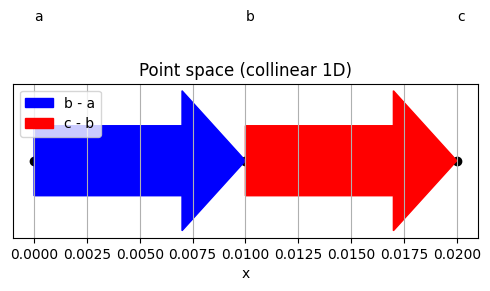

Kernel matrix K:
 [[1.         0.60653066 0.13533528]
 [0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]
cond(K) = 9.303742767706286


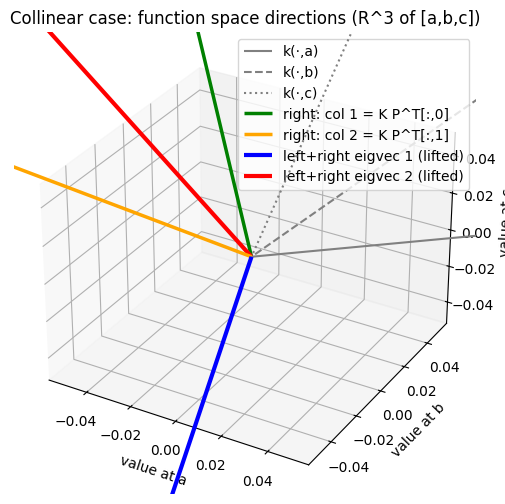


=== Collinear case ANGLES IN FUNCTION SPACE ===
Angle between d1 and d2 (right-precond): 66.03095024349945 deg
Eigenvalues of P K P^T: [7092.12644386 8646.64716763]
Angle between lifted eigvecs e1, e2: 90.0 deg

================ CASE B: NON-COLLINEAR 2D CLUSTER ================


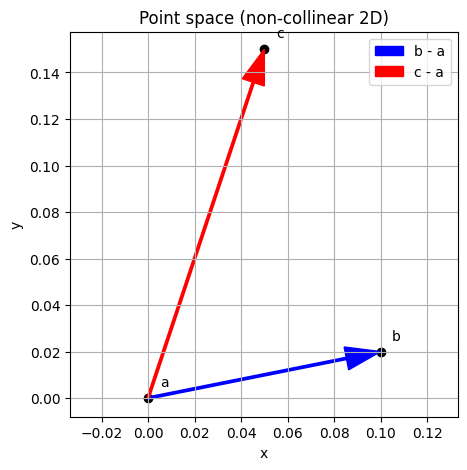

Kernel matrix K:
 [[1.         0.87809543 0.73161563]
 [0.87809543 1.         0.78466375]
 [0.73161563 0.78466375 1.        ]]
cond(K) = 22.42665337575805


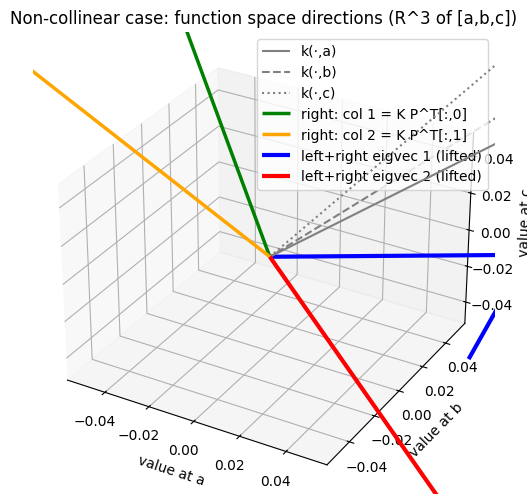


=== Non-collinear case ANGLES IN FUNCTION SPACE ===
Angle between d1 and d2 (right-precond): 59.7069876315747 deg
Eigenvalues of P K P^T: [11.56213406 33.35180199]
Angle between lifted eigvecs e1, e2: 115.09627469827232 deg


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots


# ==========================================================
# Squared Exponential kernel
# ==========================================================
def se_kernel(x, y, ell=0.1):
    x = np.asarray(x)
    y = np.asarray(y)
    return np.exp(-np.sum((x - y)**2) / (2 * ell**2))


def build_K(points, ell=0.1):
    n = len(points)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = se_kernel(points[i], points[j], ell=ell)
    return K


# ==========================================================
# Preconditioner builders
# ==========================================================
def build_P_collinear(points_1d):
    """
    3 points in 1D: x1 < x2 < x3.
    Use forward differences between neighbors (2x3 P).
    """
    x1, x2, x3 = [p[0] for p in points_1d]
    h1 = x2 - x1
    h2 = x3 - x2
    P = np.array([
        [-1/h1,  1/h1,   0.0],
        [ 0.0,  -1/h2,  1/h2]
    ])
    return P


def build_P_noncollinear(points_2d):
    """
    3 non-collinear points in 2D.
    Use differences (b-a) and (c-a), scaled by their norms.
    """
    a, b, c = points_2d
    v1 = b - a
    v2 = c - a
    P = np.array([
        [-1/np.linalg.norm(v1),  1/np.linalg.norm(v1), 0.0],
        [-1/np.linalg.norm(v2),  0.0,                  1/np.linalg.norm(v2)]
    ])
    return P


# ==========================================================
# Visualization helpers
# ==========================================================
def plot_point_geometry_collinear(points_1d, ax):
    xs = [p[0] for p in points_1d]
    ys = [0, 0, 0]
    labels = ['a', 'b', 'c']

    ax.scatter(xs, ys, color='black')
    for x, y, lab in zip(xs, ys, labels):
        ax.text(x, y+0.002, lab)

    # geometric directions v1 = b - a, v2 = c - b
    v1 = xs[1] - xs[0]
    v2 = xs[2] - xs[1]
    ax.arrow(xs[0], 0, v1, 0, head_width=0.002, length_includes_head=True,
             color='blue', label='b - a')
    ax.arrow(xs[1], 0, v2, 0, head_width=0.002, length_includes_head=True,
             color='red', label='c - b')

    ax.set_title("Point space (collinear 1D)")
    ax.set_xlabel("x")
    ax.get_yaxis().set_visible(False)
    ax.grid(True)
    ax.legend()


def plot_point_geometry_noncollinear(points_2d, ax):
    a, b, c = points_2d
    xs = [a[0], b[0], c[0]]
    ys = [a[1], b[1], c[1]]
    labels = ['a', 'b', 'c']

    ax.scatter(xs, ys, color='black')
    for x, y, lab in zip(xs, ys, labels):
        ax.text(x+0.005, y+0.005, lab)

    # geometric directions
    v1 = b - a
    v2 = c - a
    ax.arrow(a[0], a[1], v1[0], v1[1], head_width=0.01, length_includes_head=True,
             color='blue', label='b - a')
    ax.arrow(a[0], a[1], v2[0], v2[1], head_width=0.01, length_includes_head=True,
             color='red', label='c - a')

    ax.set_title("Point space (non-collinear 2D)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.legend()
    ax.axis('equal')


def plot_function_space_directions(K, P, title_prefix):
    """
    Plot in kernel function space R^3:
      - original kernel columns
      - right-preconditioned difference directions
      - left+right preconditioned eigendirections (lifted back)
    """
    # Original basis: columns of K
    k1 = K[:, 0]
    k2 = K[:, 1]
    k3 = K[:, 2]

    # Right preconditioning: K P^T gives two columns (difference kernels)
    KP_T = K @ P.T      # shape (3, 2)
    d1 = KP_T[:, 0]
    d2 = KP_T[:, 1]

    # Symmetric preconditioning: P K P^T is 2x2; eigendirections in "derivative space"
    K_sym = P @ K @ P.T  # (2x2)
    eigvals, eigvecs = np.linalg.eigh(K_sym)  # columns of eigvecs are eigenvectors

    # Lift eigenvectors back to function space via P^T
    e1 = P.T @ eigvecs[:, 0]
    e2 = P.T @ eigvecs[:, 1]

    # Normalize everything for direction-only visualization
    def norm_or_zero(v):
        n = np.linalg.norm(v)
        return v / n if n > 0 else v

    k1n, k2n, k3n = map(norm_or_zero, (k1, k2, k3))
    d1n, d2n = map(norm_or_zero, (d1, d2))
    e1n, e2n = map(norm_or_zero, (e1, e2))

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"{title_prefix}: function space directions (R^3 of [a,b,c])")

    # origin
    ox, oy, oz = 0, 0, 0

    # Original kernel columns
    ax.quiver(ox, oy, oz, k1n[0], k1n[1], k1n[2], color='gray', linewidth=1.5, label='k(·,a)')
    ax.quiver(ox, oy, oz, k2n[0], k2n[1], k2n[2], color='gray', linewidth=1.5, linestyle='--', label='k(·,b)')
    ax.quiver(ox, oy, oz, k3n[0], k3n[1], k3n[2], color='gray', linewidth=1.5, linestyle=':', label='k(·,c)')

    # Right-preconditioned difference directions
    ax.quiver(ox, oy, oz, d1n[0], d1n[1], d1n[2], color='green', linewidth=2.5,
              label='right: col 1 = K P^T[:,0]')
    ax.quiver(ox, oy, oz, d2n[0], d2n[1], d2n[2], color='orange', linewidth=2.5,
              label='right: col 2 = K P^T[:,1]')

    # Left+right eigendirections lifted back
    ax.quiver(ox, oy, oz, e1n[0], e1n[1], e1n[2], color='blue', linewidth=3,
              label='left+right eigvec 1 (lifted)')
    ax.quiver(ox, oy, oz, e2n[0], e2n[1], e2n[2], color='red', linewidth=3,
              label='left+right eigvec 2 (lifted)')

    ax.set_xlabel("value at a")
    ax.set_ylabel("value at b")
    ax.set_zlabel("value at c")
    ax.legend()
    plt.show()

    # Print angles to see (near-)collinearity
    def angle_deg(u, v):
        nu, nv = np.linalg.norm(u), np.linalg.norm(v)
        if nu == 0 or nv == 0:
            return np.nan
        cos = np.clip(np.dot(u/nu, v/nv), -1.0, 1.0)
        return np.degrees(np.arccos(cos))

    print(f"\n=== {title_prefix} ANGLES IN FUNCTION SPACE ===")
    print("Angle between d1 and d2 (right-precond):", angle_deg(d1, d2), "deg")
    print("Eigenvalues of P K P^T:", eigvals)
    print("Angle between lifted eigvecs e1, e2:", angle_deg(e1, e2), "deg")


# ==========================================================
# MAIN: Case C (both collinear 1D and non-collinear 2D)
# ==========================================================
def run_case_collinear():
    print("\n================ CASE A: COLLINEAR 1D CLUSTER ================")
    # 1D collinear points
    points_1d = [np.array([0.00]), np.array([0.01]), np.array([0.02])]

    # Point-space plot
    fig, ax = plt.subplots(figsize=(6, 2))
    plot_point_geometry_collinear(points_1d, ax)
    plt.show()

    # Kernel + preconditioning
    K = build_K(points_1d, ell=0.01)  # small lengthscale to emphasize ill-conditioning
    P = build_P_collinear(points_1d)

    print("Kernel matrix K:\n", K)
    print("cond(K) =", np.linalg.cond(K))

    # Function-space visualization
    plot_function_space_directions(K, P, title_prefix="Collinear case")


def run_case_noncollinear():
    print("\n================ CASE B: NON-COLLINEAR 2D CLUSTER ================")
    # 2D non-collinear points
    a = np.array([0.0, 0.0])
    b = np.array([0.1, 0.02])
    c = np.array([0.05, 0.15])
    points_2d = [a, b, c]

    # Point-space plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_point_geometry_noncollinear(points_2d, ax)
    plt.show()

    # Kernel + preconditioning
    K = build_K(points_2d, ell=0.2)
    P = build_P_noncollinear(points_2d)

    print("Kernel matrix K:\n", K)
    print("cond(K) =", np.linalg.cond(K))

    # Function-space visualization
    plot_function_space_directions(K, P, title_prefix="Non-collinear case")


# Run both
run_case_collinear()
run_case_noncollinear()



=========== CASE A: COLLINEAR ===========
Collinear P =
 [[-9.74480345e+09  9.74480345e+09  0.00000000e+00]
 [-4.87240172e+09  0.00000000e+00  4.87240172e+09]]
cond(K) = 3.726030268361793e+16


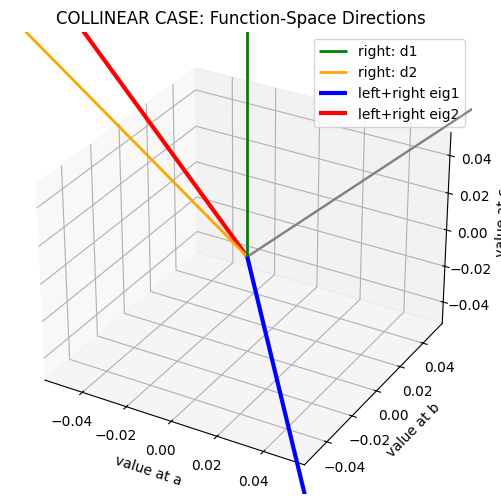

Eigenvalues (P K P^T): [-6691.83400913 16609.92360436]
Angle(d1,d2) = 48.60418623825739 degrees

=========== CASE B: NON-COLLINEAR ===========
Non-collinear P =
 [[-9.55556595e+10  9.55556595e+10  0.00000000e+00]
 [-1.39307601e+05  0.00000000e+00  1.39307601e+05]]
cond(K) = 3.181230233515745e+17


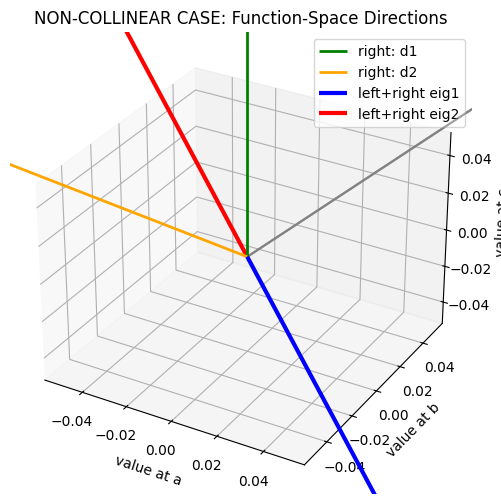

Eigenvalues (P K P^T): [-5.75284436 30.75284589]
Angle(d1,d2) = 54.7355890498845 degrees


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# ==========================================================
# Squared Exponential kernel
# ==========================================================
def se_kernel(x, y, ell=0.1):
    x = np.asarray(x)
    y = np.asarray(y)
    return np.exp(-np.sum((x - y)**2) / (2 * ell**2))


def build_K(points, ell=0.1):
    n = len(points)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = se_kernel(points[i], points[j], ell=ell)
    return K


# ==========================================================
# YOUR P BUILDER (used for both collinear & non-collinear)
# ==========================================================
def build_P_noncollinear(points):
    """
    Your given code:
    Uses differences (b-a) and (c-a)
    scaled by their norms.
    """
    a, b, c = points
    v1 = b - a
    v2 = c - a
    P = np.array([
        [-1/np.linalg.norm(v1),  1/np.linalg.norm(v1), 0.0],
        [-1/np.linalg.norm(v2),  0.0,                  1/np.linalg.norm(v2)]
    ])
    return P


# ==========================================================
# Helper: Normalize vectors safely
# ==========================================================
def normalize(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v


# ==========================================================
# Function-space visualization
# ==========================================================
def plot_function_space(K, P, title_prefix):

    k1, k2, k3 = K[:, 0], K[:, 1], K[:, 2]
    KP_T = K @ P.T
    d1, d2 = KP_T[:,0], KP_T[:,1]

    # symmetric P K P^T
    K_sym = P @ K @ P.T
    eigvals, eigvecs = np.linalg.eigh(K_sym)
    e1 = P.T @ eigvecs[:, 0]
    e2 = P.T @ eigvecs[:, 1]

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title(f"{title_prefix}: Function-Space Directions")

    # origin
    ox, oy, oz = 0, 0, 0

    # original kernel columns
    for vec, lab in [(k1,"k(·,a)"),(k2,"k(·,b)"),(k3,"k(·,c)")]:
        vn = normalize(vec)
        ax.quiver(ox, oy, oz, vn[0], vn[1], vn[2], color='gray', alpha=0.7)

    # right-preconditioned
    d1n, d2n = normalize(d1), normalize(d2)
    ax.quiver(ox, oy, oz, d1n[0], d1n[1], d1n[2], color='green', linewidth=2, label='right: d1')
    ax.quiver(ox, oy, oz, d2n[0], d2n[1], d2n[2], color='orange', linewidth=2, label='right: d2')

    # left+right lifted eigendirections
    e1n, e2n = normalize(e1), normalize(e2)
    ax.quiver(ox, oy, oz, e1n[0], e1n[1], e1n[2], color='blue', linewidth=3, label='left+right eig1')
    ax.quiver(ox, oy, oz, e2n[0], e2n[1], e2n[2], color='red', linewidth=3, label='left+right eig2')

    ax.set_xlabel("value at a")
    ax.set_ylabel("value at b")
    ax.set_zlabel("value at c")
    ax.legend()
    plt.show()

    # Print info
    print("Eigenvalues (P K P^T):", eigvals)
    print("Angle(d1,d2) =", angle_deg(d1,d2), "degrees")


# ==========================================================
# Angle calculator
# ==========================================================
def angle_deg(u, v):
    nu, nv = np.linalg.norm(u), np.linalg.norm(v)
    if nu == 0 or nv == 0:
        return np.nan
    cos = np.dot(u/nu, v/nv)
    cos = np.clip(cos, -1, 1)
    return np.degrees(np.arccos(cos))


# ==========================================================
# RUN CASES
# ==========================================================
def run_case_collinear():
    print("\n=========== CASE A: COLLINEAR ===========")

    # collinear cluster (1D)
    a = np.array([0.00])
    b = np.array([np.exp(-23.0)])
    c = np.array([2*np.exp(-23.0)])
    pts = [a,b,c]

    K = build_K(pts, ell=0.01)
    P = build_P_noncollinear(pts)   # << using same P method

    print("Collinear P =\n", P)
    print("cond(K) =", np.linalg.cond(K))

    plot_function_space(K, P, "COLLINEAR CASE")


def run_case_noncollinear():
    print("\n=========== CASE B: NON-COLLINEAR ===========")

    # non-collinear cluster (2D)
    a = np.array([0.0, 0.0])
    b = np.array([0.1*np.exp(-23.0), 0.02*np.exp(-23.0)])
    c = np.array([0.05*np.exp(-10.0), 0.15*np.exp(-10.0)])
    pts = [a,b,c]

    K = build_K(pts, ell=0.2)
    P = build_P_noncollinear(pts)   # << same P builder

    print("Non-collinear P =\n", P)
    print("cond(K) =", np.linalg.cond(K))

    plot_function_space(K, P, "NON-COLLINEAR CASE")


# Run both
run_case_collinear()
run_case_noncollinear()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider

# squared exponential kernel
def k(x, y, ell=0.1):
    return np.exp(-(x-y)**2 / (2*ell**2))

def build_K(h, ell=0.1):
    a = 0.0
    b = h
    c = 2*h
    pts = [a,b,c]
    K = np.zeros((3,3))
    for i,x in enumerate(pts):
        for j,y in enumerate(pts):
            K[i,j] = k(x,y,ell)
    return K

def build_P(h):
    # P for evenly spaced collinear points
    return np.array([
        [-1/h,  1/h, 0],
        [0,    -1/h, 1/h]
    ])

def visualize_preconditioning(h):
    K = build_K(h)
    P = build_P(h)

    # right-preconditioned
    KP = K @ P.T

    # left+right preconditioned
    Ksym = P @ K @ P.T

    # --- plots ---
    fig,ax = plt.subplots(1,3,figsize=(15,4))

    im0 = ax[0].imshow(K, cmap="viridis")
    ax[0].set_title(f"K cond={np.linalg.cond(K):.2e}")
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    # ---- K P^T ----
    im1 = ax[1].imshow(KP, cmap="viridis")
    ax[1].set_title(f"K P^T cond={np.linalg.cond(KP):.2e}")
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    # ---- P K P^T ----
    im2 = ax[2].imshow(Ksym, cmap="viridis")
    ax[2].set_title(f"P K P^T cond={np.linalg.cond(Ksym):.2e}")
    plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    print(K)
    print(KP)
    print(Ksym)

    plt.show()

    print("Eigenvalues of P K P^T =", np.linalg.eigvals(Ksym))

interact(
    visualize_preconditioning,
    h=FloatLogSlider(
        base=10,
        min=-5,
        max=0,
        step=0.01,
        description="spacing h"
    )
)


interactive(children=(FloatLogSlider(value=1.0, description='spacing h', max=0.0, min=-5.0, step=0.01), Output…

<function __main__.visualize_preconditioning(h)>

In [ ]:
# condK      = np.nan_to_num(condK, nan=1e300, posinf=1e300, neginf=1e-300)
# condKP     = np.nan_to_num(condKP, nan=1e300, posinf=1e300, neginf=1e-300)
# condKsym   = np.nan_to_num(condKsym, nan=1e300, posinf=1e300, neginf=1e-300)
# # ---- Plot surfaces with log10(cond) ----
# fig = plt.figure(figsize=(18,6))

# ax1 = fig.add_subplot(131, projection='3d')
# ax1.plot_surface(D1, D2, np.log10(condK), cmap='viridis')
# ax1.set_title("log10(cond(K))")
# ax1.set_xlabel("d1")
# ax1.set_ylabel("d2")
# ax1.set_zlabel("log10(cond)")

# ax2 = fig.add_subplot(132, projection='3d')
# ax2.plot_surface(D1, D2, np.log10(condKP), cmap='plasma')
# ax2.set_title("log10(cond(K Pᵀ))")
# ax2.set_xlabel("d1")
# ax2.set_ylabel("d2")
# ax2.set_zlabel("log10(cond)")

# ax3 = fig.add_subplot(133, projection='3d')
# ax3.plot_surface(D1, D2, np.log10(condKsym), cmap='inferno')
# ax3.set_title("log10(cond(P K Pᵀ))")
# ax3.set_xlabel("d1")
# ax3.set_ylabel("d2")
# ax3.set_zlabel("log10(cond)")

# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # build_K and build_P definitions …

# # ---- 1. logspace sweep for d1, d2 ----
# d_vals = np.logspace(-10, -23, 50)
# D1, D2 = np.meshgrid(d_vals, d_vals)

# condK      = np.zeros_like(D1)
# condKP     = np.zeros_like(D1)
# condKsym   = np.zeros_like(D1)

# # ---- 2. compute condition numbers ----
# for i in range(len(d_vals)):
#     for j in range(len(d_vals)):
#         d1, d2 = D1[i,j], D2[i,j]
#         K = build_K(d1, d2)
#         P = build_P(d1, d2)
#         KP   = K @ P.T
#         Ksym = P @ K @ P.T
#         condK[i,j]    = np.linalg.cond(K)
#         condKP[i,j]   = np.linalg.cond(KP)
#         condKsym[i,j] = np.linalg.cond(Ksym)

# # clamp infinities for log plotting
# condK      = np.nan_to_num(condK, nan=1e300, posinf=1e300)
# condKP     = np.nan_to_num(condKP, nan=1e300, posinf=1e300)
# condKsym   = np.nan_to_num(condKsym, nan=1e300, posinf=1e300)

# # ---- 3. PLOT log10 surfaces ----
# fig = plt.figure(figsize=(18,6))

# ax1 = fig.add_subplot(131, projection='3d')
# ax1.plot_surface(D1, D2, np.log10(condK), cmap='viridis')
# ax1.set_title("log10(cond(K))")

# ax2 = fig.add_subplot(132, projection='3d')
# ax2.plot_surface(D1, D2, np.log10(condKP), cmap='plasma')
# ax2.set_title("log10(cond(K Pᵀ))")

# ax3 = fig.add_subplot(133, projection='3d')
# ax3.plot_surface(D1, D2, np.log10(condKsym), cmap='inferno')
# ax3.set_title("log10(cond(P K Pᵀ))")

# plt.tight_layout()
# plt.show()


/usr/local/lib/python3.12/dist-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


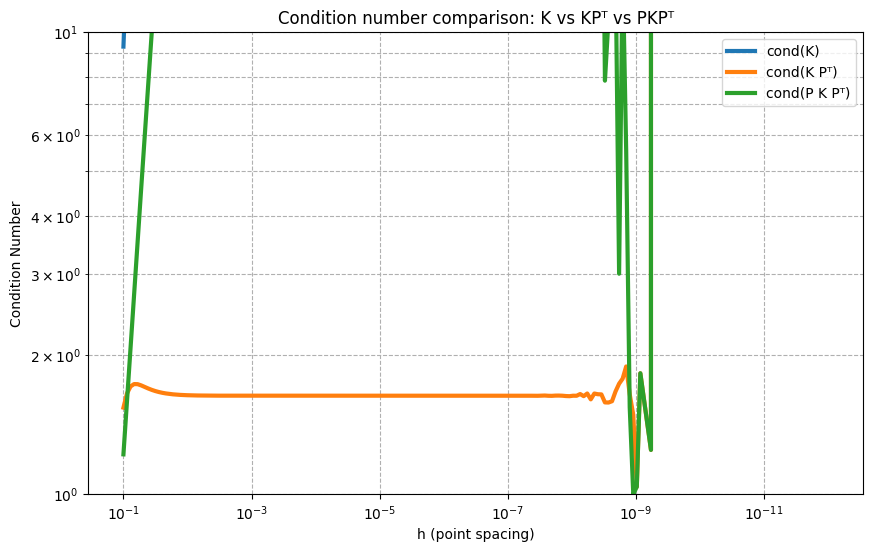

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================================================
# Kernel and preconditioner
# =====================================================================

def k(x, y, ell=0.1):
    return np.exp(-(x - y)**2 / (2 * ell**2))

def build_K(h, ell=0.1):
    pts = [0.0, h, 2*h]
    K = np.zeros((3,3))
    for i,x in enumerate(pts):
        for j,y in enumerate(pts):
            K[i,j] = k(x, y, ell)
    return K

def build_P(h):
    return np.array([
        [-1/h,  1/h,  0.0],
        [ 0.0, -1/h,  1/h]
    ])

# =====================================================================
# Sweep over h
# =====================================================================

h_vals = np.logspace(-12, -1, 200)

condK   = []
condR   = []   # cond(KP^T)
condLR  = []   # cond(PKP^T)

for h in h_vals:
    K  = build_K(h)
    P  = build_P(h)

    R  = K @ P.T
    LR = P @ K @ P.T

    condK.append(  np.linalg.cond(K)  )
    condR.append(  np.linalg.cond(R)  )
    condLR.append( np.linalg.cond(LR) )

condK   = np.array(condK)
condR   = np.array(condR)
condLR  = np.array(condLR)

# Replace infinities for stability in log-plot
condK[~np.isfinite(condK)]     = 1e308
condR[~np.isfinite(condR)]     = 1e308
condLR[~np.isfinite(condLR)]   = 1e308

# =====================================================================
# Plot comparative conditioning trends
# =====================================================================

plt.figure(figsize=(10,6))
plt.loglog(h_vals, condK,   label="cond(K)",        linewidth=3)
plt.loglog(h_vals, condR,   label="cond(K Pᵀ)",     linewidth=3)
plt.loglog(h_vals, condLR,  label="cond(P K Pᵀ)",   linewidth=3)

plt.gca().invert_xaxis()
plt.xlabel("h (point spacing)")
plt.ylabel("Condition Number")
plt.title("Condition number comparison: K vs KPᵀ vs PKPᵀ")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


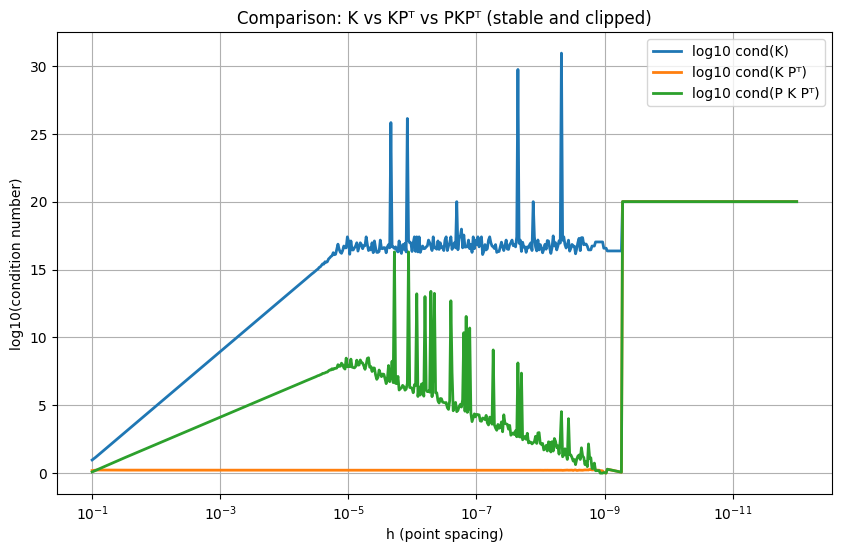

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def k(x, y, ell=0.1):
    return np.exp(-(x-y)**2 / (2*ell**2))

def build_K(h):
    pts = [0.0, h, 2*h]
    K = np.zeros((3,3))
    for i,x in enumerate(pts):
        for j,y in enumerate(pts):
            K[i,j] = k(x,y)
    return K

def build_P(h):
    return np.array([
        [-1/h, 1/h, 0],
        [0, -1/h, 1/h]
    ])


# ============================================================
# 1. Sweep h
# ============================================================
h_vals = np.logspace(-12, -1, 600)

condK, condR, condLR = [], [], []

for h in h_vals:
    K = build_K(h)
    P = build_P(h)
    R  = K @ P.T
    LR = P @ K @ P.T

    # raw cond numbers
    cK  = np.linalg.cond(K)
    cR  = np.linalg.cond(R)
    cLR = np.linalg.cond(LR)

    condK.append(cK)
    condR.append(cR)
    condLR.append(cLR)

condK  = np.array(condK)
condR  = np.array(condR)
condLR = np.array(condLR)

# ============================================================
# 2. Stabilize for log plotting
# ============================================================
MAXY = 1e20  # cap values
condK  = np.nan_to_num(condK,  nan=MAXY, posinf=MAXY, neginf=1e-30)
condR  = np.nan_to_num(condR,  nan=MAXY, posinf=MAXY, neginf=1e-30)
condLR = np.nan_to_num(condLR, nan=MAXY, posinf=MAXY, neginf=1e-30)

logK  = np.log10(condK)
logR  = np.log10(condR)
logLR = np.log10(condLR)

# clip absurd values
# logK  = np.clip(logK,  -5, 20)
# logR  = np.clip(logR,  -5, 20)
# logLR = np.clip(logLR, -5, 20)

# ============================================================
# 3. Plot
# ============================================================
plt.figure(figsize=(10,6))

plt.semilogx(h_vals, logK,  label="log10 cond(K)",        linewidth=2)
plt.semilogx(h_vals, logR,  label="log10 cond(K Pᵀ)",     linewidth=2)
plt.semilogx(h_vals, logLR, label="log10 cond(P K Pᵀ)",   linewidth=2)

plt.gca().invert_xaxis()
plt.xlabel("h (point spacing)")
plt.ylabel("log10(condition number)")
plt.title("Comparison: K vs KPᵀ vs PKPᵀ (stable and clipped)")
plt.grid(True, which="both")  # controlled, readable scale
plt.legend()
plt.show()


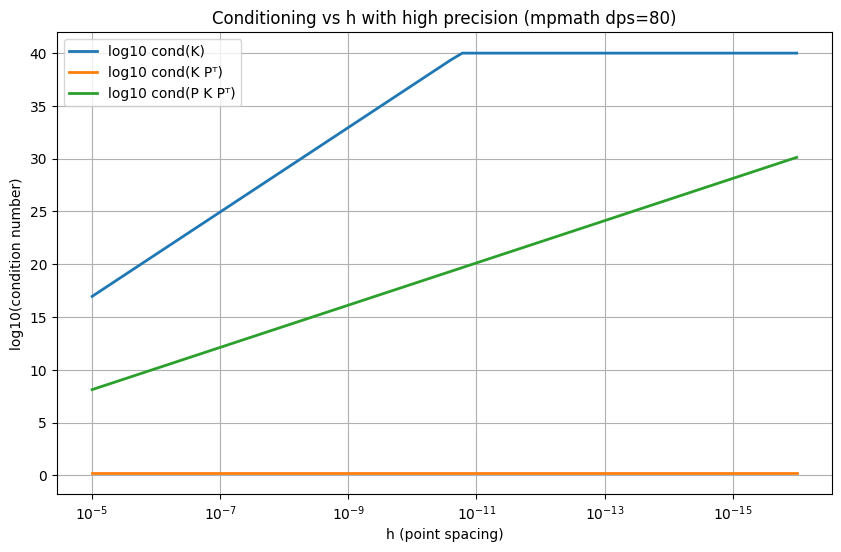

In [ ]:
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1. Set high precision
# ==========================================================
mp.mp.dps = 80  # number of decimal digits of precision

# ==========================================================
# 2. Kernel + preconditioner in mpmath
# ==========================================================
def k_mp(x, y, ell=mp.mpf('0.1')):
    return mp.e ** (-(x - y)**2 / (2 * ell**2))

def build_K_mp(h, ell=mp.mpf('0.1')):
    pts = [mp.mpf('0'), h, 2*h]
    K = mp.matrix(3, 3)
    for i in range(3):
        for j in range(3):
            K[i, j] = k_mp(pts[i], pts[j], ell)
    return K

def build_P_mp(h):
    h = mp.mpf(h)
    return mp.matrix([
        [-1/h,  1/h,  mp.mpf('0')],
        [ mp.mpf('0'), -1/h, 1/h]
    ])

def cond_mp(M):
    """
    High-precision condition number using mpmath SVD.
    """
    U, svals, V = mp.svd(M)          # svals is a 1D list-like of singular values
    smax = max(svals)
    smin = min(svals)
    if smin == 0:
        return mp.mpf('inf')
    return smax / smin

# ==========================================================
# 3. Sweep h values (10^-5 to 10^-16 for example)
# ==========================================================
exponents = np.linspace(5, 16, 60)  # adjust range if you like
h_vals_mp = [mp.power(10, -mp.mpf(e)) for e in exponents]

condK_mp  = []
condR_mp  = []
condLR_mp = []

for h in h_vals_mp:
    K  = build_K_mp(h)
    P  = build_P_mp(h)
    R  = K * P.T
    LR = P * K * P.T

    condK_mp.append(cond_mp(K))
    condR_mp.append(cond_mp(R))
    condLR_mp.append(cond_mp(LR))

# ==========================================================
# 4. Convert to floats via log10 for plotting
# ==========================================================
h_vals = np.array([float(h) for h in h_vals_mp])
logK   = np.array([float(mp.log10(c)) if c != mp.inf else np.inf for c in condK_mp])
logR   = np.array([float(mp.log10(c)) if c != mp.inf else np.inf for c in condR_mp])
logLR  = np.array([float(mp.log10(c)) if c != mp.inf else np.inf for c in condLR_mp])

# clip infinities to keep the plot readable
UPPER = 40
logK  = np.clip(logK,  -5, UPPER)
logR  = np.clip(logR,  -5, UPPER)
logLR = np.clip(logLR, -5, UPPER)

# ==========================================================
# 5. Plot: log10(condition number) vs h
# ==========================================================
plt.figure(figsize=(10,6))

plt.semilogx(h_vals, logK,  label="log10 cond(K)",        linewidth=2)
plt.semilogx(h_vals, logR,  label="log10 cond(K Pᵀ)",     linewidth=2)
plt.semilogx(h_vals, logLR, label="log10 cond(P K Pᵀ)",   linewidth=2)

plt.gca().invert_xaxis()
plt.xlabel("h (point spacing)")
plt.ylabel("log10(condition number)")
plt.title("Conditioning vs h with high precision (mpmath dps=80)")
plt.grid(True, which="both")
plt.legend()
plt.show()


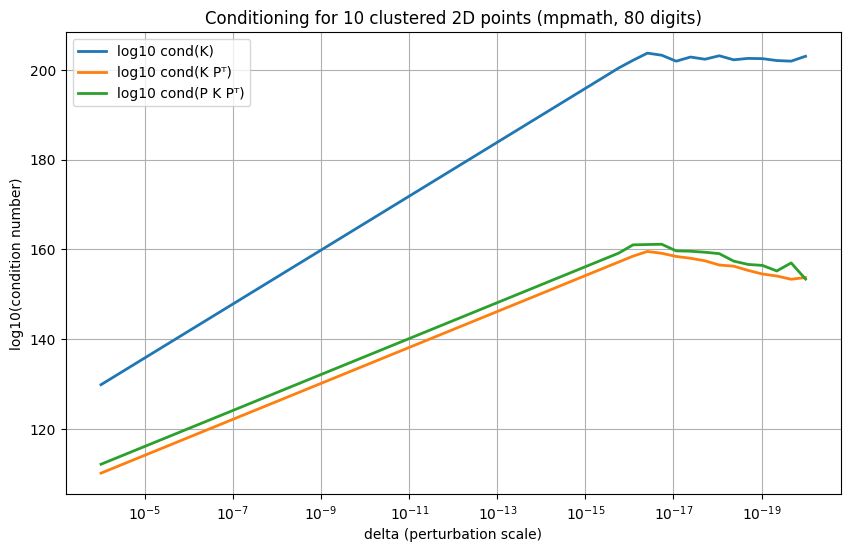

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

# ============================================================
# High precision
# ============================================================
mp.mp.dps = 200   # increase if needed

# ============================================================
# Kernel + preconditioning matrices
# ============================================================
def k_mp(x, y, ell=mp.mpf('0.1')):
    dx = x[0] - y[0]
    dy = x[1] - y[1]
    r2 = dx*dx + dy*dy
    return mp.e ** (-r2 / (2*ell*ell))

def build_K_mp(points):
    n = len(points)
    K = mp.matrix(n, n)
    for i in range(n):
        for j in range(n):
            K[i,j] = k_mp(points[i], points[j])
    return K

def build_P_mp(points):
    n = len(points)
    P = mp.matrix(n-1, n)
    for i in range(n-1):
        p_i = points[i]
        p_j = points[i+1]
        dx = mp.sqrt((p_j[0]-p_i[0])**2 + (p_j[1]-p_i[1])**2)
        if dx == 0:
            P[i,i], P[i,i+1] = mp.mpf('0'), mp.mpf('0')
        else:
            P[i,i], P[i,i+1] = -1/dx, 1/dx
    return P

def cond_mp(M):
    U, svals, V = mp.svd(M)
    smax = max(svals)
    smin = min(svals)
    return mp.mpf('inf') if smin == 0 else smax/smin

# ============================================================
# Build 10 clustered 2D points around a, b, c with perturbation δ
# ============================================================
def build_points(delta):
    delta = mp.mpf(delta)

    # ---- hard-coded 10 tiny clustered points ----
    pts0 = [
        [0.0, 0.0],
        [1e-22,  2e-22],
        [2e-22, -1e-22],

        [0.1*np.exp(-23),  0.02*np.exp(-23)],
        [0.1*np.exp(-23)+1e-23,  0.02*np.exp(-23)-2e-23],

        [0.05*np.exp(-10), 0.15*np.exp(-10)],
        [0.05*np.exp(-10)+1e-12, 0.15*np.exp(-10)+3e-12],
        [0.05*np.exp(-10)-2e-12, 0.15*np.exp(-10)-1e-12],

        [3e-22, -4e-22],
        [-2e-22, 5e-22]
    ]

    # ---- scale each point by delta ----
    pts_delta = [
        [delta * mp.mpf(p[0]), delta * mp.mpf(p[1])]
        for p in pts0
    ]

    return pts_delta


# ============================================================
# Sweep δ values
# ============================================================
deltas = [mp.mpf(10)**(-mp.mpf(e)) for e in np.linspace(4, 20, 50)]

condK_list, condR_list, condLR_list = [], [], []

for delta in deltas:
    pts = build_points(delta)
    K  = build_K_mp(pts)
    P  = build_P_mp(pts)
    R  = K * P.T
    LR = P * K * P.T

    condK_list.append( cond_mp(K) )
    condR_list.append( cond_mp(R) )
    condLR_list.append(cond_mp(LR))

# ============================================================
# Convert to log10 floats for plotting
# ============================================================
def safe_log10(vals):
    arr = []
    for v in vals:
        if v == mp.inf:
            arr.append(np.inf)
        else:
            arr.append(float(mp.log10(v)))
    return np.array(arr)

# logK  = np.clip(safe_log10(condK_list),  -2, 40)
# logR  = np.clip(safe_log10(condR_list),  -2, 40)
# logLR = np.clip(safe_log10(condLR_list), -2, 40)

logK = safe_log10(condK_list)
logR = safe_log10(condR_list)
logLR = safe_log10(condLR_list)
delta_np = np.array([float(d) for d in deltas])

# ============================================================
# Plot results
# ============================================================
plt.figure(figsize=(10,6))

plt.semilogx(delta_np, logK,  label="log10 cond(K)",        linewidth=2)
plt.semilogx(delta_np, logR,  label="log10 cond(K Pᵀ)",     linewidth=2)
plt.semilogx(delta_np, logLR, label="log10 cond(P K Pᵀ)",   linewidth=2)

print()


plt.gca().invert_xaxis()
plt.xlabel("delta (perturbation scale)")
plt.ylabel("log10(condition number)")
plt.title("Conditioning for 10 clustered 2D points (mpmath, 80 digits)")
plt.grid(True, which='both')
plt.legend()
plt.show()


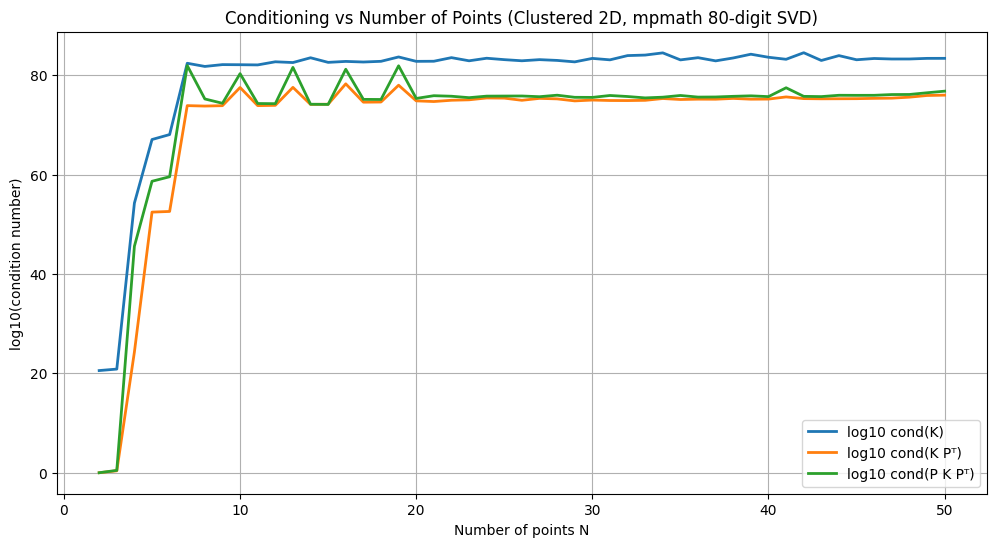

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 80  # high precision

# ============================================================
# 1) Hard-coded 100 clustered points (tiny scales)
# ============================================================
# Base cluster centers
a = np.array([0.0, 0.0])
b = np.array([0.1*np.exp(-23), 0.02*np.exp(-23)])
c = np.array([0.05*np.exp(-10), 0.15*np.exp(-10)])

# Generate a deterministic 100-point cluster (no randomness)
pts0 = []
for i in range(100):
    if i % 3 == 0:
        base = a
        off  = np.array([ i*1e-24, -i*1e-24 ])
    elif i % 3 == 1:
        base = b
        off  = np.array([ i*5e-25, i*3e-25 ])
    else:
        base = c
        off  = np.array([ i*2e-12, -i*1e-12 ])
    p = base + off
    pts0.append([mp.mpf(p[0]), mp.mpf(p[1])])

# You can also uniformly scale the cluster if desired:
def get_points(N, delta=1):
    delta = mp.mpf(delta)
    return [[delta*pts0[i][0], delta*pts0[i][1]] for i in range(N)]


# ============================================================
# 2) Kernel + Preconditioners
# ============================================================
def k_mp(x, y, ell=mp.mpf('0.1')):
    dx = x[0]-y[0]
    dy = x[1]-y[1]
    return mp.e**(-(dx*dx + dy*dy)/(2*ell*ell))

def build_K_mp(points):
    n = len(points)
    K = mp.matrix(n,n)
    for i in range(n):
        for j in range(n):
            K[i,j] = k_mp(points[i], points[j])
    return K

def build_P_mp(points):
    n = len(points)
    if n <= 1:
        return mp.matrix(0, n)
    P = mp.matrix(n-1, n)
    for i in range(n-1):
        p = points[i]
        q = points[i+1]
        d = mp.sqrt((q[0]-p[0])**2 + (q[1]-p[1])**2)
        if d == 0:
            P[i,i], P[i,i+1] = mp.mpf('0'), mp.mpf('0')
        else:
            P[i,i], P[i,i+1] = -1/d, 1/d
    return P

def cond_mp(M):
    if M.rows == 0 or M.cols == 0:
        return mp.mpf(1)
    U, svals, V = mp.svd(M)
    smax = max(svals)
    smin = min(svals)
    if smin == 0:
        return mp.mpf('inf')
    return smax/smin


# ============================================================
# 3) Sweep N = 2 → 100
# ============================================================
Ns = list(range(2, 51))
condK  = []
condR  = []
condLR = []

for N in Ns:
    pts = get_points(N)
    K   = build_K_mp(pts)
    P   = build_P_mp(pts)
    R   = K * P.T
    LR  = P * K * P.T

    condK.append(cond_mp(K))
    condR.append(cond_mp(R))
    condLR.append(cond_mp(LR))


# ============================================================
# 4) Convert for plotting
# ============================================================
def safe_log10(vals, clip_low=-2, clip_high=80):
    arr = []
    for v in vals:
        if v == mp.inf:
            arr.append(clip_high)
        else:
            arr.append(float(mp.log10(v)))
    return np.array(arr)

logK  = safe_log10(condK)
logR  = safe_log10(condR)
logLR = safe_log10(condLR)


# ============================================================
# 5) Plot results
# ============================================================
plt.figure(figsize=(12,6))
plt.plot(Ns, logK,  label="log10 cond(K)",        linewidth=2)
plt.plot(Ns, logR,  label="log10 cond(K Pᵀ)",     linewidth=2)
plt.plot(Ns, logLR, label="log10 cond(P K Pᵀ)",   linewidth=2)

plt.xlabel("Number of points N")
plt.ylabel("log10(condition number)")
plt.title("Conditioning vs Number of Points (Clustered 2D, mpmath 80-digit SVD)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 80

# ---------------- Stable difference using expm1 ------------------
def stable_kernel_diff(x_i, x_j, x_k, ell=mp.mpf('0.1')):
    dij2 = (x_i[0]-x_j[0])**2 + (x_i[1]-x_j[1])**2
    dik2 = (x_i[0]-x_k[0])**2 + (x_i[1]-x_k[1])**2
    fac = mp.e ** ( -dik2 / (2*ell*ell) )
    z = (dik2 - dij2) / (2*ell*ell)
    return fac * mp.expm1(z)

def build_D_expm1(points, ell=mp.mpf('0.1')):
    n = len(points)
    D = mp.matrix(n, n-1)
    for i in range(n):
        for r in range(n-1):
            D[i,r] = stable_kernel_diff(points[i], points[r], points[r+1], ell)
    return D

def cond_mp(M):
    U, svals, V = mp.svd(M)
    smax, smin = max(svals), min(svals)
    return mp.mpf('inf') if smin == 0 else smax/smin


# ------------- Example: 3 clustered points (you can replace) --------------
pts = [
    [mp.mpf(0), mp.mpf(0)],
    [mp.mpf(1e-22), mp.mpf(2e-22)],
    [mp.mpf(2e-22), mp.mpf(-1e-22)],
]

# Build K
def k_mp(a,b,ell=mp.mpf('0.1')):
    dx, dy = a[0]-b[0], a[1]-b[1]
    return mp.e**(-(dx*dx+dy*dy)/(2*ell*ell))

def build_K_mp(pts):
    n=len(pts)
    K=mp.matrix(n,n)
    for i in range(n):
        for j in range(n):
            K[i,j]=k_mp(pts[i],pts[j])
    return K

K = build_K_mp(pts)
D = build_D_expm1(pts)
S = D.T * K * D

print("cond(K)          =", cond_mp(K))
print("cond(KPᵀ approx) =", cond_mp(K * D))
print("cond(P K Pᵀ expm1) =", cond_mp(S))


cond(K)          = 1799999999999999825051612424344872282170142.5936988538157868054119062984123762532
cond(KPᵀ approx) = 122474487139158893006134179206871521300802.30504868864941916074074666585382435295
cond(P K Pᵀ expm1) = 24999999999999997570161283671456559474570.109657077725122846891582056820755560693


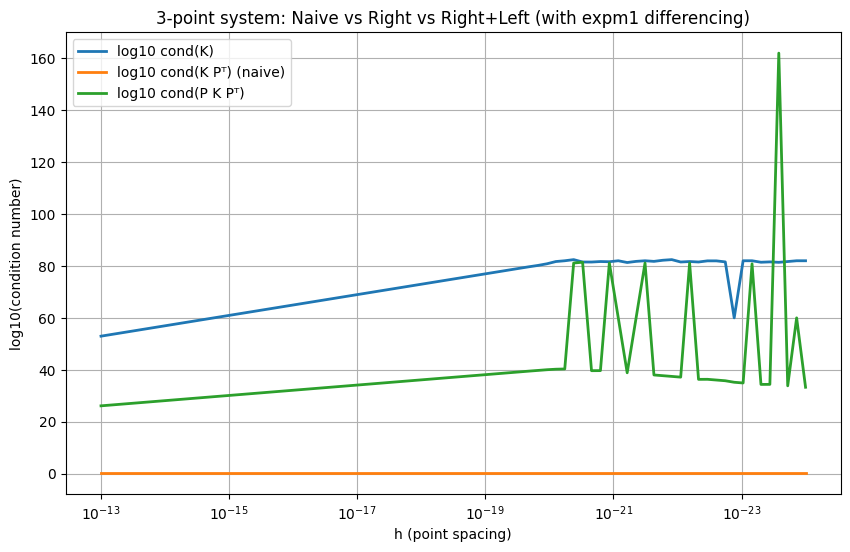

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

# ============================================
# High precision
# ============================================
mp.mp.dps = 80  # decimal digits

# ============================================
# Kernel and stable difference
# ============================================
def k_mp(x, y, ell=mp.mpf('1')):
    d = x - y
    return mp.e ** (-(d*d) / (2*ell*ell))

def stable_diff_divh(x_i, x_j, x_k, h, ell=mp.mpf('1')):
    """
    Compute (k(x_i,x_j) - k(x_i,x_k)) / h using the expm1-based identity:

      k_ij - k_ik = exp(-rho_ik^2/2) * (exp((rho_ik^2 - rho_ij^2)/2) - 1)

    where rho^2 = (distance/ell)^2, to avoid cancellation when k_ij ~ k_ik ~ 1.
    """
    # scaled squared distances
    rho2_ij = (x_i - x_j)**2 / (ell*ell)
    rho2_ik = (x_i - x_k)**2 / (ell*ell)

    fac = mp.e ** (-rho2_ik / 2)         # exp(-rho_ik^2/2)
    z   = (rho2_ik - rho2_ij) / 2        # (rho_ik^2 - rho_ij^2)/2

    diff = fac * mp.expm1(z)             # exp(-rho_ik^2/2) * (exp(z) - 1)
    return diff / h                      # divide by h to match P's scaling


def build_K_mp(h, ell=mp.mpf('1')):
    xs = [mp.mpf('0'), h, 2*h]
    K = mp.matrix(3,3)
    for i in range(3):
        for j in range(3):
            K[i,j] = k_mp(xs[i], xs[j], ell)
    return K, xs

def build_P_mp(h):
    h = mp.mpf(h)
    return mp.matrix([
        [-1/h,  1/h,  mp.mpf('0')],
        [ mp.mpf('0'), -1/h, 1/h]
    ])

def build_R_naive(K, P):
    # Right-preconditioned (naive) = K P^T
    return K * P.T

def build_R_expm1(xs, h, ell=mp.mpf('1')):
    """
    Build the 3x2 right-preconditioned matrix using stable expm1-based differences.
    Columns correspond to:
      col0 ~ (k(·, x1) - k(·, x0)) / h
      col1 ~ (k(·, x2) - k(·, x1)) / h
    """
    x0, x1, x2 = xs
    R = mp.matrix(3, 2)
    for i, x_i in enumerate(xs):
        R[i,0] = stable_diff_divh(x_i, x1, x0, h, ell)
        R[i,1] = stable_diff_divh(x_i, x2, x1, h, ell)
    return R

def cond_mp(M):
    U, svals, V = mp.svd(M)
    smax = max(svals)
    smin = min(svals)
    return mp.mpf('inf') if smin == 0 else smax/smin

# ============================================
# Sweep over h and compute condition numbers
# ============================================
exponents = np.linspace(13, 24, 80)   # h = 10^{-2} ... 10^{-14}
h_vals_mp = [mp.power(10, -mp.mpf(e)) for e in exponents]

condK_list      = []
condR_naive_list = []
condR_exp_list   = []
condLR_list     = []

for h in h_vals_mp:
    K, xs = build_K_mp(h)
    P     = build_P_mp(h)

    R_naive = build_R_naive(K, P)
    R_exp   = build_R_expm1(xs, h)

    LR = P * K * P.T   # left+right preconditioning

    condK_list.append(        cond_mp(K)      )
    condR_naive_list.append(  cond_mp(R_naive))
    condR_exp_list.append(    cond_mp(R_exp)  )
    condLR_list.append(       cond_mp(LR)     )

# ============================================
# Convert to log10 floats for plotting
# ============================================
def safe_log10(cond_list, clip_low=-5, clip_high=60):
    arr = []
    for c in cond_list:
        if c == mp.inf:
            arr.append(clip_high)
        else:
            arr.append(float(mp.log10(c)))
    return np.array(arr)

logK      = safe_log10(condK_list)
logR_naive = safe_log10(condR_naive_list)
logR_exp   = safe_log10(condR_exp_list)
logLR     = safe_log10(condLR_list)

h_vals = np.array([float(h) for h in h_vals_mp])

# ============================================
# Plot: log10(cond) vs h
# ============================================
plt.figure(figsize=(10,6))

plt.semilogx(h_vals, logK,       label="log10 cond(K)",              linewidth=2)
plt.semilogx(h_vals, logR_naive, label="log10 cond(K Pᵀ) (naive)",   linewidth=2)
# plt.semilogx(h_vals, logR_exp,   label="log10 cond(K·diff) (expm1)", linewidth=2)
plt.semilogx(h_vals, logLR,      label="log10 cond(P K Pᵀ)",         linewidth=2)

plt.gca().invert_xaxis()
plt.xlabel("h (point spacing)")
plt.ylabel("log10(condition number)")
plt.title("3-point system: Naive vs Right vs Right+Left (with expm1 differencing)")
plt.grid(True, which="both")
plt.legend()
plt.show()


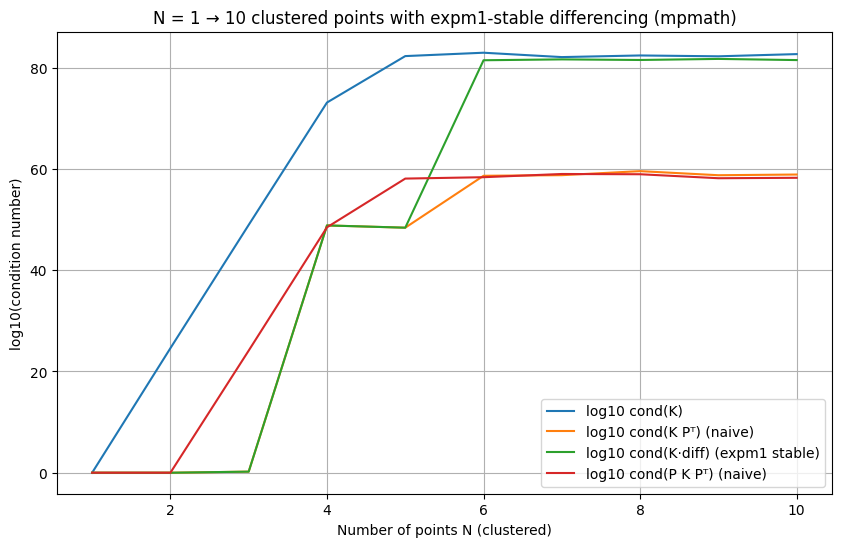

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 80   # high precision

# ============================================================
# Kernel and stable expm1 difference
# ============================================================

def k_mp(x, y, ell=mp.mpf('1')):
    d = x - y
    return mp.e ** (-(d*d) / (2*ell*ell))

def stable_diff_divh(x_i, x_j, x_k, h, ell=mp.mpf('1')):
    """
    Computes (k(x_i,x_j) - k(x_i,x_k)) / h using the expm1 identity:

      k_ij - k_ik = exp(-rho_ik^2/2) * (exp(z) - 1)

    where z = (rho_ik^2 - rho_ij^2) / 2.
    """
    rho2_ij = (x_i - x_j)**2 / (ell*ell)
    rho2_ik = (x_i - x_k)**2 / (ell*ell)

    fac = mp.e ** (-rho2_ik / 2)
    z   = (rho2_ik - rho2_ij) / 2

    return (fac * mp.expm1(z)) / h


# ============================================================
# Build K, P, R_naive, R_expm1, LR for N points
# ============================================================

def build_points_N(N, h):
    return [mp.mpf(i)*h for i in range(N)]  # 0, h, 2h, ...

def build_K(points, ell=mp.mpf('1')):
    N = len(points)
    K = mp.matrix(N, N)
    for i in range(N):
        for j in range(N):
            K[i,j] = k_mp(points[i], points[j], ell)
    return K

def build_P(points):
    """
    Standard first-difference matrix for 1D:
      P[i,i] = -1/h_i, P[i,i+1] = 1/h_i
    All h_i equal = h.
    """
    N = len(points)
    if N <= 1:
        return mp.matrix(0, N)
    P = mp.matrix(N-1, N)
    for i in range(N-1):
        h = points[i+1] - points[i]
        P[i,i]   = -1/h
        P[i,i+1] =  1/h
    return P

def build_R_expm1(points, ell=mp.mpf('1')):
    """
    expm1-based stable right preconditioning matrix.
    Dimension: Nx(N-1)
    """
    N = len(points)
    if N <= 1:
        return mp.matrix(N, 0)
    R = mp.matrix(N, N-1)
    for r in range(N-1):
        xj = points[r]
        xk = points[r+1]
        h  = xk - xj
        for i in range(N):
            xi = points[i]
            R[i,r] = stable_diff_divh(xi, xj, xk, h, ell)
    return R


# ============================================================
# Condition number
# ============================================================
def cond_mp(M):
    if M.rows == 0 or M.cols == 0:
        return mp.mpf(1)
    U, svals, V = mp.svd(M)
    smax, smin = max(svals), min(svals)
    return mp.mpf('inf') if smin == 0 else smax/smin


# ============================================================
# Sweep N = 1 → 10 at a fixed cluster spacing h
# ============================================================

h = mp.mpf('1e-12')   # you can vary this!
Ns = range(1, 11)

condK, condR_naive, condR_exp, condLR = [], [], [], []

for N in Ns:
    pts = build_points_N(N, h)
    K   = build_K(pts)
    P   = build_P(pts)
    Rn  = K * P.T         # naive right-preconditioning
    Re  = build_R_expm1(pts)  # stable using expm1
    LR  = P * K * P.T     # symmetric left+right

    condK.append(cond_mp(K))
    condR_naive.append(cond_mp(Rn))
    condR_exp.append(cond_mp(Re))
    condLR.append(cond_mp(LR))


# ============================================================
# Convert to log10 for plotting
# ============================================================
def safe_log10(values, clip_low=-5, clip_high=60):
    arr = []
    for v in values:
        arr.append(clip_high if v == mp.inf else float(mp.log10(v)))
    return np.array(arr)

logK      = safe_log10(condK)
logR_naive = safe_log10(condR_naive)
logR_exp   = safe_log10(condR_exp)
logLR     = safe_log10(condLR)

# ============================================================
# Plot
# ============================================================
plt.figure(figsize=(10,6))
plt.plot(list(Ns), logK,       label="log10 cond(K)")
plt.plot(list(Ns), logR_naive, label="log10 cond(K Pᵀ) (naive)")
plt.plot(list(Ns), logR_exp,   label="log10 cond(K·diff) (expm1 stable)")
plt.plot(list(Ns), logLR,      label="log10 cond(P K Pᵀ) (naive)")

plt.xlabel("Number of points N (clustered)")
plt.ylabel("log10(condition number)")
plt.title("N = 1 → 10 clustered points with expm1-stable differencing (mpmath)")
plt.grid(True)
plt.legend()
plt.show()


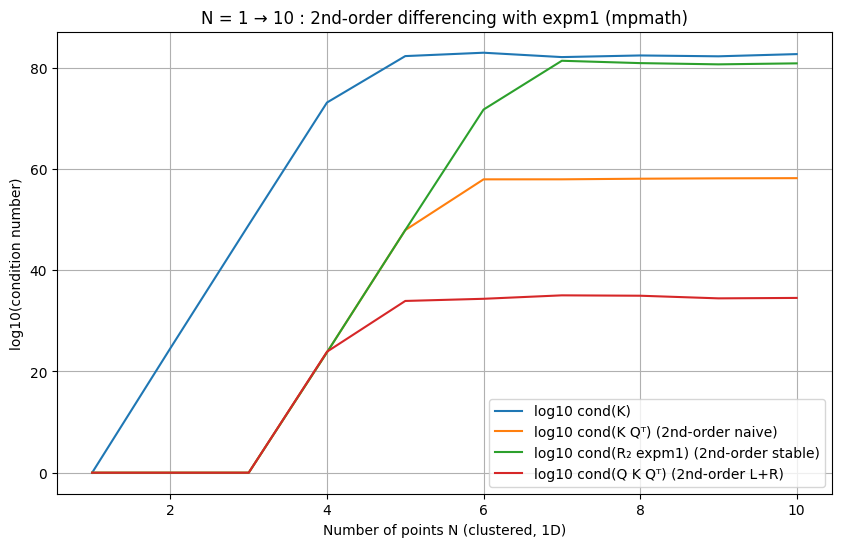

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 80  # high precision

# ============================================================
# Kernel and stable 2nd-order expm1-based difference
# ============================================================

def k_mp(x, y, ell=mp.mpf('1')):
    d = x - y
    return mp.e ** (-(d*d) / (2*ell*ell))

def stable_second_diff_divh2(x_i, x_j, x_k, x_l, h, ell=mp.mpf('1')):
    """
    Stable computation of (k(x_i,x_j) - 2k(x_i,x_k) + k(x_i,x_l)) / h^2
    using expm1-based identity.

    j = left neighbor, k = center, l = right neighbor.
    """
    # scaled squared distances rho^2 = ((x_i - x_m)/ell)^2
    rho2_ij = (x_i - x_j)**2 / (ell*ell)
    rho2_ik = (x_i - x_k)**2 / (ell*ell)
    rho2_il = (x_i - x_l)**2 / (ell*ell)

    fac = mp.e ** (-rho2_ik / 2)                      # exp(-rho_ik^2/2)
    z1  = (rho2_ik - rho2_ij) / 2
    z2  = (rho2_ik - rho2_il) / 2

    # exp(-rho_ik^2/2)*[(exp(z1)-1) + (exp(z2)-1)]
    num = fac * (mp.expm1(z1) + mp.expm1(z2))
    return num / (h*h)


# ============================================================
# Build points, K, second-diff matrix Q, R_naive, R_expm1, LR
# ============================================================

def build_points_N(N, h):
    # uniform 1D grid: 0, h, 2h, ...
    return [mp.mpf(i)*h for i in range(N)]

def build_K(points, ell=mp.mpf('1')):
    N = len(points)
    K = mp.matrix(N, N)
    for i in range(N):
        for j in range(N):
            K[i,j] = k_mp(points[i], points[j], ell)
    return K

def build_Q(points):
    """
    Second-order difference matrix Q of size (N-2) x N, with rows like:
    [ ..., 1/h^2, -2/h^2, 1/h^2, ... ]
    """
    N = len(points)
    if N < 3:
        return mp.matrix(0, N)
    Q = mp.matrix(N-2, N)
    for r in range(N-2):
        x_left   = points[r]
        x_center = points[r+1]
        x_right  = points[r+2]
        h = x_center - x_left  # assume uniform spacing
        val = 1/(h*h)
        Q[r, r]   = val
        Q[r, r+1] = -2*val
        Q[r, r+2] = val
    return Q

def build_R2_expm1(points, ell=mp.mpf('1')):
    """
    Stable right-preconditioned 2nd-order matrix R2_expm1 of size N x (N-2),
    where each column corresponds to a second-diff stencil (j,k,l).
    """
    N = len(points)
    if N < 3:
        return mp.matrix(N, 0)
    R = mp.matrix(N, N-2)
    for r in range(N-2):
        x_j = points[r]
        x_k = points[r+1]
        x_l = points[r+2]
        h   = x_k - x_j  # spacing
        for i in range(N):
            x_i = points[i]
            R[i, r] = stable_second_diff_divh2(x_i, x_j, x_k, x_l, h, ell)
    return R

def cond_mp(M):
    if M.rows == 0 or M.cols == 0:
        return mp.mpf(1)
    U, svals, V = mp.svd(M)
    smax, smin = max(svals), min(svals)
    return mp.mpf('inf') if smin == 0 else smax/smin


# ============================================================
# Case study: N = 1 → 10 clustered points, fixed tiny h
# ============================================================

h = mp.mpf('1e-12')     # small spacing between points (cluster)
Ns = range(1, 11)

condK      = []
condR2_naive = []
condR2_exp   = []
condLR2    = []

for N in Ns:
    pts = build_points_N(N, h)
    K   = build_K(pts)
    Q   = build_Q(pts)
    R2_exp = build_R2_expm1(pts)

    # naive 2nd-order right-preconditioning: K Q^T
    R2_naive = K * Q.T if Q.rows > 0 else mp.matrix(N, 0)
    # symmetric 2nd-order left+right: Q K Q^T
    LR2 = Q * K * Q.T if Q.rows > 0 else mp.matrix(0, 0)

    condK.append(      cond_mp(K)       )
    condR2_naive.append(cond_mp(R2_naive))
    condR2_exp.append(  cond_mp(R2_exp) )
    condLR2.append(    cond_mp(LR2)     )


# ============================================================
# Convert to log10 for plotting
# ============================================================

def safe_log10(vals, clip_low=-5, clip_high=100):
    arr = []
    for v in vals:
        arr.append(clip_high if v == mp.inf else float(mp.log10(v)))
    return np.clip(np.array(arr), clip_low, clip_high)

logK        = safe_log10(condK)
logR2_naive = safe_log10(condR2_naive)
logR2_exp   = safe_log10(condR2_exp)
logLR2      = safe_log10(condLR2)


# ============================================================
# Plot results
# ============================================================

plt.figure(figsize=(10,6))

plt.plot(list(Ns), logK,        label="log10 cond(K)")
plt.plot(list(Ns), logR2_naive, label="log10 cond(K Qᵀ) (2nd-order naive)")
plt.plot(list(Ns), logR2_exp,   label="log10 cond(R₂ expm1) (2nd-order stable)")
plt.plot(list(Ns), logLR2,      label="log10 cond(Q K Qᵀ) (2nd-order L+R)")

plt.xlabel("Number of points N (clustered, 1D)")
plt.ylabel("log10(condition number)")
plt.title("N = 1 → 10 : 2nd-order differencing with expm1 (mpmath)")
plt.grid(True)
plt.legend()
plt.show()


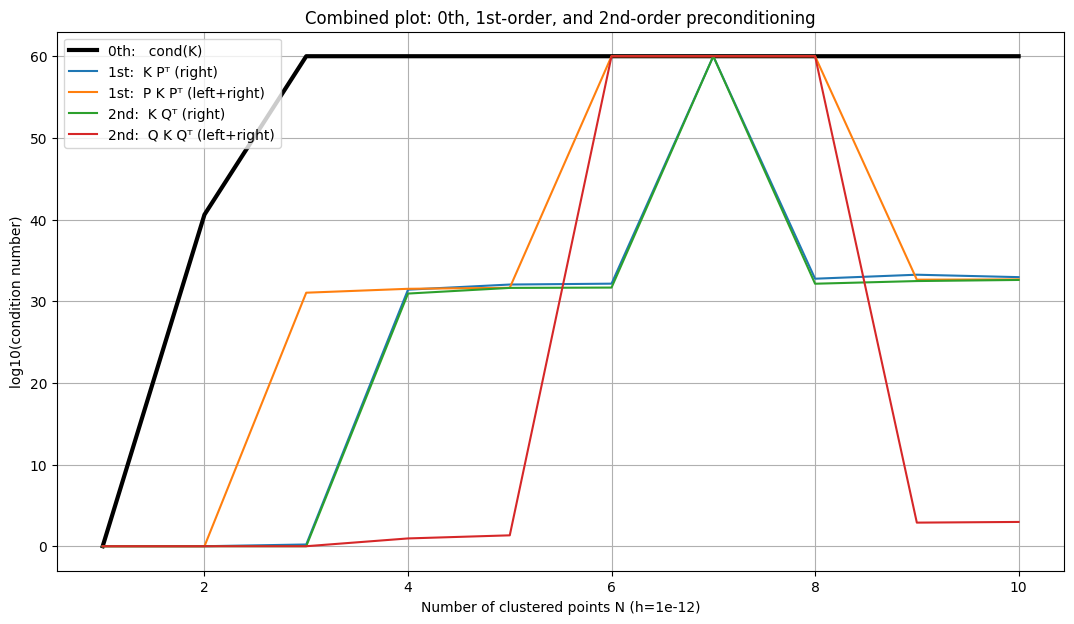

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 70  # high precision

# ============================================================
# Kernel
# ============================================================

def k_mp(x, y, ell=mp.mpf('1')):
    d = x - y
    return mp.e ** (-(d*d)/(2*ell*ell))


# ============================================================
# Build points, K, P, Q
# ============================================================

def build_points_N(N, h):
    return [mp.mpf(i)*h for i in range(N)]

def build_K(points):
    N = len(points)
    K = mp.matrix(N, N)
    for i in range(N):
        for j in range(N):
            K[i,j] = k_mp(points[i], points[j])
    return K

def build_P(points):
    N = len(points)
    if N <= 1:
        return mp.matrix(0, N)
    P = mp.matrix(N-1, N)
    for r in range(N-1):
        h = points[r+1] - points[r]
        P[r,r] = -1/h
        P[r,r+1] = 1/h
    return P

def build_Q(points):
    N = len(points)
    if N < 3:
        return mp.matrix(0, N)
    Q = mp.matrix(N-2, N)
    for r in range(N-2):
        h = points[r+1] - points[r]
        Q[r,r]   =  1/(h*h)
        Q[r,r+1] = -2/(h*h)
        Q[r,r+2] =  1/(h*h)
    return Q


# ============================================================
# Condition number
# ============================================================

def cond_mp(M):
    if M.rows == 0 or M.cols == 0:
        return mp.mpf(1)
    U, svals, V = mp.svd(M)
    if min(svals) == 0:
        return mp.mpf('inf')
    return max(svals)/min(svals)

def safe_log(vals, lo=-5, hi=60):
    out=[]
    for v in vals:
        out.append(hi if v==mp.inf else float(mp.log10(v)))
    return np.clip(np.array(out), lo, hi)


# ============================================================
# Experiment: N = 1 → 10
# ============================================================

h = mp.mpf('1e-20')
Ns = list(range(1, 11))

K_vals   = []
R1_vals  = []
RL1_vals = []
R2_vals  = []
RL2_vals = []

for N in Ns:
    pts = build_points_N(N, h)
    K = build_K(pts)
    P = build_P(pts)
    Q = build_Q(pts)

    K_vals.append(cond_mp(K))

    # 1st-order naive
    R1  = K * P.T  if P.rows>0 else mp.matrix(N,0)
    RL1 = P * K * P.T if P.rows>0 else mp.matrix(0,0)
    R1_vals.append(cond_mp(R1))
    RL1_vals.append(cond_mp(RL1))

    # 2nd-order naive
    R2  = K * Q.T if Q.rows>0 else mp.matrix(N,0)
    RL2 = Q * K * Q.T if Q.rows>0 else mp.matrix(0,0)
    R2_vals.append(cond_mp(R2))
    RL2_vals.append(cond_mp(RL2))


# Convert to log10
logK   = safe_log(K_vals)
logR1  = safe_log(R1_vals)
logRL1 = safe_log(RL1_vals)
logR2  = safe_log(R2_vals)
logRL2 = safe_log(RL2_vals)


# ============================================================
# Combined PLOT (only naive cases)
# ============================================================

plt.figure(figsize=(13,7))

plt.plot(Ns, logK,   label="0th:   cond(K)", linewidth=3, color='black')

# 1st order
plt.plot(Ns, logR1,  label="1st:  K Pᵀ (right)")
plt.plot(Ns, logRL1, label="1st:  P K Pᵀ (left+right)")

# 2nd order
plt.plot(Ns, logR2,  label="2nd:  K Qᵀ (right)")
plt.plot(Ns, logRL2, label="2nd:  Q K Qᵀ (left+right)")

plt.xlabel("Number of clustered points N (h=1e-12)")
plt.ylabel("log10(condition number)")
plt.title("Combined plot: 0th, 1st-order, and 2nd-order preconditioning")
plt.grid(True, which='both')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider

mp.mp.dps = 70  # high precision

# ============================================================
# Kernel
# ============================================================

def k_mp(x, y, ell=mp.mpf('1')):
    d = x - y
    return mp.e ** (-(d*d)/(2*ell*ell))

# ============================================================
# Build points + matrices
# ============================================================

def build_points_N(N, h):
    return [mp.mpf(i)*h for i in range(N)]

def build_K(points):
    N = len(points)
    K = mp.matrix(N, N)
    for i in range(N):
        for j in range(N):
            K[i,j] = k_mp(points[i], points[j])
    return K

def build_P(points):
    N = len(points)
    if N <= 1:
        return mp.matrix(0,N)
    P = mp.matrix(N-1, N)
    for r in range(N-1):
        h = points[r+1] - points[r]
        P[r,r] = -1/h
        P[r,r+1] = 1/h
    return P

def build_Q(points):
    N = len(points)
    if N < 3:
        return mp.matrix(0,N)
    Q = mp.matrix(N-2, N)
    for r in range(N-2):
        h = points[r+1] - points[r]
        Q[r,r]   =  1/(h*h)
        Q[r,r+1] = -2/(h*h)
        Q[r,r+2] =  1/(h*h)
    return Q

# ============================================================
# Condition number
# ============================================================

def cond_mp(M):
    if M.rows == 0 or M.cols == 0:
        return mp.mpf(1)
    U, svals, V = mp.svd(M)
    if min(svals) == 0:
        return mp.mpf('inf')
    return max(svals)/min(svals)

def safe_log(vals, lo=-5, hi=60):
    out = []
    for v in vals:
        out.append(hi if v == mp.inf else float(mp.log10(v)))
    return np.clip(np.array(out), lo, hi)

# ============================================================
# Interactive callback
# ============================================================

def compute_and_plot(h):

    Ns = range(1, 11)

    K_vals   = []
    R1_vals  = []
    RL1_vals = []
    R2_vals  = []
    RL2_vals = []

    h_mp = mp.mpf(h)

    for N in Ns:
        pts = build_points_N(N, h_mp)
        K = build_K(pts)
        P = build_P(pts)
        Q = build_Q(pts)

        # 0th-order baseline
        K_vals.append(cond_mp(K))

        # 1st order
        R1  = K * P.T  if P.rows>0 else mp.matrix(N,0)
        RL1 = P * K * P.T if P.rows>0 else mp.matrix(0,0)
        R1_vals.append(cond_mp(R1))
        RL1_vals.append(cond_mp(RL1))

        # 2nd order
        R2  = K * Q.T if Q.rows>0 else mp.matrix(N,0)
        RL2 = Q * K * Q.T if Q.rows>0 else mp.matrix(0,0)
        R2_vals.append(cond_mp(R2))
        RL2_vals.append(cond_mp(RL2))

    # convert to log10
    logK   = safe_log(K_vals)
    logR1  = safe_log(R1_vals)
    logRL1 = safe_log(RL1_vals)
    logR2  = safe_log(R2_vals)
    logRL2 = safe_log(RL2_vals)

    # ---- Plot ----
    plt.figure(figsize=(14,7))

    plt.plot(Ns, logK,   label="0th: cond(K)", linewidth=3, color='black')

    plt.plot(Ns, logR1,  label="1st:  K Pᵀ (right naive)")
    plt.plot(Ns, logRL1, label="1st:  P K Pᵀ (left+right naive)")

    plt.plot(Ns, logR2,  label="2nd:  K Qᵀ (right naive)")
    plt.plot(Ns, logRL2, label="2nd:  Q K Qᵀ (left+right naive)")

    plt.xlabel("N (number of clustered points)")
    plt.ylabel("log10(condition number)")
    plt.title(f"Conditioning vs N for h = {h}")
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


# ============================================================
# Create the slider
# ============================================================

interact(
    compute_and_plot,
    h=FloatLogSlider(
        base=10,
        min=-18, max=-3, step=0.1,
        value=1e-12,
        description="h spacing",
        continuous_update=False
    )
);


interactive(children=(FloatLogSlider(value=1e-12, continuous_update=False, description='h spacing', max=-3.0, …

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider

mp.mp.dps = 70  # high precision

# ============================================================
# Kernel
# ============================================================

def k_mp(x, y, ell=mp.mpf('1')):
    d = x - y
    return mp.e ** (-(d*d)/(2*ell*ell))


# ============================================================
# Build points + matrices
# ============================================================

def build_points_N(N, h):
    return [mp.mpf(i)*h for i in range(N)]

def build_K(points):
    N = len(points)
    K = mp.matrix(N, N)
    for i in range(N):
        for j in range(N):
            K[i,j] = k_mp(points[i], points[j])
    return K

def build_P(points):
    N = len(points)
    if N <= 1:
        return mp.matrix(0,N)
    P = mp.matrix(N-1, N)
    for r in range(N-1):
        h = points[r+1] - points[r]
        P[r,r] = -1/h
        P[r,r+1] = 1/h
    return P

def build_Q(points):
    N = len(points)
    if N < 3:
        return mp.matrix(0,N)
    Q = mp.matrix(N-2, N)
    for r in range(N-2):
        h = points[r+1] - points[r]
        Q[r,r]   =  1/(h*h)
        Q[r,r+1] = -2/(h*h)
        Q[r,r+2] =  1/(h*h)
    return Q


# ============================================================
# Standard and Relative Condition Number
# ============================================================

def cond_mp(M):
    if M.rows == 0 or M.cols == 0:
        return mp.mpf(1)
    U, svals, V = mp.svd(M)
    if min(svals) == 0:
        return mp.mpf('inf')
    return max(svals) / min(svals)

def cond_rel(M):
    # Relative condition number only makes sense for square AND non-empty matrices
    if M.rows == 0 or M.cols == 0:
        return mp.nan
    if M.rows != M.cols:
        return mp.nan

    # Build |M|
    AbsM = mp.matrix([
        [abs(M[i,j]) for j in range(M.cols)]
        for i in range(M.rows)
    ])

    # Inverse
    try:
        M_inv = M**-1
    except ZeroDivisionError:
        return mp.mpf('inf')

    # Build |M^{-1}|
    AbsMinv = mp.matrix([
        [abs(M_inv[i,j]) for j in range(M_inv.cols)]
        for i in range(M_inv.rows)
    ])

    Prod = AbsM * AbsMinv

    # SVD
    U, svals, V = mp.svd(Prod)
    return max(svals)

def safe_log(vals, lo=-50, hi=200):
    out = []
    for v in vals:
        out.append(hi if v == mp.inf else float(mp.log10(v)))
    return np.clip(np.array(out), lo, hi)


# ============================================================
# Interactive callback
# ============================================================

def compute_and_plot(h):

    Ns = range(1, 11)

    # Store results
    K_vals, K_rel_vals = [], []
    R1_vals, R1_rel_vals = [], []
    RL1_vals, RL1_rel_vals = [], []
    R2_vals, R2_rel_vals = [], []
    RL2_vals, RL2_rel_vals = [], []

    h_mp = mp.mpf(h)

    for N in Ns:
        pts = build_points_N(N, h_mp)
        K = build_K(pts)
        P = build_P(pts)
        Q = build_Q(pts)

        # ---- 0th order ----
        K_vals.append(cond_mp(K))
        K_rel_vals.append(cond_rel(K))

        # ---- 1st order ----
        R1  = K * P.T  if P.rows>0 else mp.matrix(N,0)
        RL1 = P * K * P.T if P.rows>0 else mp.matrix(0,0)

        R1_vals.append(cond_mp(R1))
        RL1_vals.append(cond_mp(RL1))

        R1_rel_vals.append(cond_rel(R1))
        RL1_rel_vals.append(cond_rel(RL1))

        # ---- 2nd order ----
        R2  = K * Q.T if Q.rows>0 else mp.matrix(N,0)
        RL2 = Q * K * Q.T if Q.rows>0 else mp.matrix(0,0)

        R2_vals.append(cond_mp(R2))
        RL2_vals.append(cond_mp(RL2))

        R2_rel_vals.append(cond_rel(R2))
        RL2_rel_vals.append(cond_rel(RL2))

    # Convert to log10
    logK      = safe_log(K_vals)
    logK_rel  = safe_log(K_rel_vals)

    logR1     = safe_log(R1_vals)
    logR1_rel = safe_log(R1_rel_vals)

    logRL1     = safe_log(RL1_vals)
    logRL1_rel = safe_log(RL1_rel_vals)

    logR2     = safe_log(R2_vals)
    logR2_rel = safe_log(R2_rel_vals)

    logRL2     = safe_log(RL2_vals)
    logRL2_rel = safe_log(RL2_rel_vals)

    # ---- Plot ----
    plt.figure(figsize=(15,8))

    plt.plot(Ns, logK,     label="cond(K)", color="black", linewidth=3)
    plt.plot(Ns, logK_rel, label="scaled cond(K)", color="black", linestyle="--")

    plt.plot(Ns, logR1,     label="1st: cond(K Pᵀ)")
    plt.plot(Ns, logR1_rel, label="1st: scaled cond(K Pᵀ)", linestyle="--")

    plt.plot(Ns, logRL1,     label="1st: cond(P K Pᵀ)")
    plt.plot(Ns, logRL1_rel, label="1st: scaled cond(P K Pᵀ)", linestyle="--")

    plt.plot(Ns, logR2,     label="2nd: cond(K Qᵀ)")
    plt.plot(Ns, logR2_rel, label="2nd: scaled cond(K Qᵀ)", linestyle="--")

    plt.plot(Ns, logRL2,     label="2nd: cond(Q K Qᵀ)")
    plt.plot(Ns, logRL2_rel, label="2nd: scaled cond(Q K Qᵀ)", linestyle="--")

    plt.xlabel("N (number of clustered points)")
    plt.ylabel("log10(condition number)")
    plt.title(f"Conditioning vs N for h = {h}")
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


# ============================================================
# Create the slider
# ============================================================

interact(
    compute_and_plot,
    h=FloatLogSlider(
        base=10,
        min=-18, max=-3, step=0.1,
        value=1e-12,
        description="h spacing",
        continuous_update=False
    )
);


interactive(children=(FloatLogSlider(value=1e-12, continuous_update=False, description='h spacing', max=-3.0, …

Absolute Condition Numbers:
R naive    : 6.078e+01
RL naive   : 4.346e+01
R stable   : 8.292e+16
RL stable  : 1.489e+18

Relative Condition Numbers:
RL naive   : 4.544e+01
RL stable  : 2.078e+17


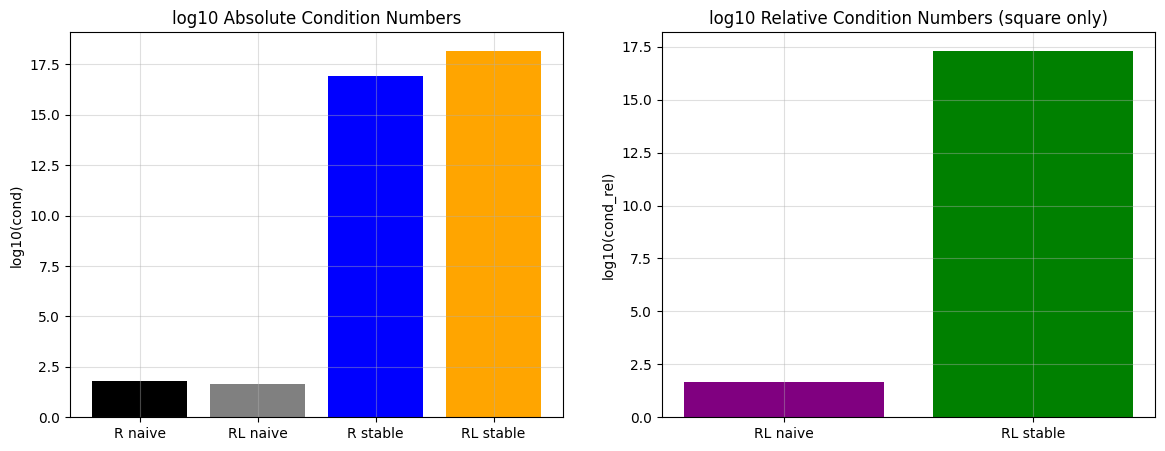

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Squared exponential kernel
# ============================================================

def k_se(x, y, ell=1.0):
    d = x - y
    return np.exp(-(d*d)/(2*ell*ell))

# ============================================================
# Build clustered points
# ============================================================

def make_points(N=10, h=1e-8):
    return np.arange(N) * h

# ============================================================
# Build K matrix
# ============================================================

def build_K(points):
    N = len(points)
    K = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            K[i,j] = k_se(points[i], points[j])
    return K

# ============================================================
# First-difference matrix P
# ============================================================

def build_P(points):
    N = len(points)
    h = points[1] - points[0]
    P = np.zeros((N-1, N))
    for r in range(N-1):
        P[r,r]   = -1.0/h
        P[r,r+1] =  1.0/h
    return P

# ============================================================
# Stable SE difference using expm1 trick
# ============================================================

def stable_se_difference(points, K):
    N = len(points)
    h = points[1] - points[0]
    R = np.zeros((N, N-1))

    for j in range(N-1):
        xj   = points[j]
        xjp1 = points[j+1]

        rij2 = (points - xj)**2
        rik2 = (points - xjp1)**2

        k_i = np.exp(-0.5 * rik2)
        u   = 0.5 * (rik2 - rij2)

        diff = k_i * np.expm1(-u)
        R[:,j] = diff / h

    return R

# ============================================================
# Condition numbers
# ============================================================

def cond_absolute(A):
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    if s[-1] == 0:
        return np.inf
    return s[0] / s[-1]

def cond_relative(A):
    if A.shape[0] != A.shape[1]:
        return np.nan

    AbsA = np.abs(A)
    try:
        Ainv = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        return np.inf

    AbsInv = np.abs(Ainv)
    M = AbsA @ AbsInv

    _, s, _ = np.linalg.svd(M, full_matrices=False)
    return s[0]

# ============================================================
# Run toy experiment
# ============================================================

N = 10
h = 1e-8
pts = make_points(N, h)
K   = build_K(pts)
P   = build_P(pts)

# Naive differencing
R1_naive  = K @ P.T
RL1_naive = P @ K @ P.T

# Stable SE differencing
R1_stable  = stable_se_difference(pts, K)
RL1_stable = P @ R1_stable

# ============================================================
# Compute all condition numbers
# ============================================================

abs_data = {
    "R naive":  cond_absolute(R1_naive),
    "RL naive": cond_absolute(RL1_naive),
    "R stable": cond_absolute(R1_stable),
    "RL stable":cond_absolute(RL1_stable),
}

rel_data = {
    "RL naive": cond_relative(RL1_naive),
    "RL stable":cond_relative(RL1_stable),
}

print("Absolute Condition Numbers:")
for k,v in abs_data.items():
    print(f"{k:10s} : {v:.3e}")

print("\nRelative Condition Numbers:")
for k,v in rel_data.items():
    print(f"{k:10s} : {v:.3e}")

# ============================================================
# Plotting
# ============================================================

fig, ax = plt.subplots(1, 2, figsize=(14,5))

# ----- absolute -----
labels_abs = list(abs_data.keys())
vals_abs   = [abs_data[k] for k in labels_abs]

ax[0].bar(labels_abs, np.log10(vals_abs), color=['black','gray','blue','orange'])
ax[0].set_title("log10 Absolute Condition Numbers")
ax[0].set_ylabel("log10(cond)")
ax[0].grid(True, alpha=0.4)

# ----- relative -----
labels_rel = list(rel_data.keys())
vals_rel   = [rel_data[k] for k in labels_rel]

ax[1].bar(labels_rel, np.log10(vals_rel), color=['purple','green'])
ax[1].set_title("log10 Relative Condition Numbers (square only)")
ax[1].set_ylabel("log10(cond_rel)")
ax[1].grid(True, alpha=0.4)

plt.show()
